In [1]:
import numpy as np
import networkx as nx
import json

In [2]:
import heapq

def dijkstra(graph, start_node):
    """
    Dijkstra's algorithm to find the shortest paths from a single source node.

    Args:
        graph (dict): A dictionary representing the graph where keys are nodes
                      and values are lists of tuples (neighbor, weight).
        start_node: The starting node for the algorithm.

    Returns:
        dict: A dictionary containing the shortest distances from the start node
              to all other nodes in the graph.
    """
    distances = {node: float('inf') for node in graph}
    distances[start_node] = 0
    priority_queue = [(0, start_node)]  # (distance, node)
    visited = set()

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_node in visited:
            continue
        visited.add(current_node)

        for neighbor, weight in graph.get(current_node, []):
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance, neighbor))

    return distances

# Example graph from the previous explanation
example_graph = {
    'A': [('B', 2), ('A', 3)],
    'B': [('C', 5), ('D', 1)],
    'C': [('D', 4)],
    'D': [('A', 2)]
}

# Apply Dijkstra's algorithm starting from node 'A'
start_node = 'A'
shortest_distances = dijkstra(example_graph, start_node)

# Print the results
print(f"Shortest distances from node '{start_node}':")
for node, distance in shortest_distances.items():
    print(f"To node {node}: {distance}")

Shortest distances from node 'A':
To node A: 0
To node B: 2
To node C: 7
To node D: 3


In [3]:
def dfs_paths_of_length(graph, start_node, length):
    """
    Finds all paths of a specified length in a directed and weighted graph using Depth-First Search (DFS).

    Args:
        graph: A dictionary representing the graph where keys are nodes and values are lists of (neighbor, weight) tuples.
        start_node: The starting node for the paths.
        length: The desired length of the paths.

    Returns:
        A list of paths, where each path is a list of nodes.  Returns an empty list if no paths of the specified length are found.
    """

    paths = []

    def dfs(current_node, current_path, current_length):
        """
        Recursive DFS helper function.
        """
        if current_length == length:
            paths.append(current_path.copy())  # Append a copy to avoid modification issues
            return

        if current_length > length:
            return  # Prune paths that are already too long

        if current_node not in graph:
            return  # Dead end: node has no outgoing edges

        for neighbor, _ in graph[current_node]:  # Iterate through neighbors (ignore weight for path finding)
            current_path.append(neighbor)
            dfs(neighbor, current_path, current_length + 1)
            current_path.pop()  # Backtrack: remove the neighbor to explore other paths

    dfs(start_node, [start_node], 0)
    return paths


# Example Usage and Testing
if __name__ == "__main__":
    # Example Graph (Directed and Weighted)
    graph = {
    'A': [('B', 2), ('A', 3)],
    'B': [('C', 5), ('D', 1)],
    'C': [('D', 4)],
    'D': [('A', 2)]
}

    start_node = 'A'
    path_length = 3

    paths = dfs_paths_of_length(graph, start_node, path_length)

    print(f"Paths of length {path_length} starting from node {start_node}:")
    if paths:
        for path in paths:
            print(path)
    else:
        print("No paths found of the specified length.")

    # Test case 2:  Different start node and length
    start_node = 'B'
    path_length = 2
    paths = dfs_paths_of_length(graph, start_node, path_length)
    print(f"\nPaths of length {path_length} starting from node {start_node}:")
    if paths:
        for path in paths:
            print(path)
    else:
        print("No paths found of the specified length.")

Paths of length 3 starting from node A:
['A', 'B', 'C', 'D']
['A', 'B', 'D', 'A']
['A', 'A', 'B', 'C']
['A', 'A', 'B', 'D']
['A', 'A', 'A', 'B']
['A', 'A', 'A', 'A']

Paths of length 2 starting from node B:
['B', 'C', 'D']
['B', 'D', 'A']


In [4]:
class Cube:
    def __init__(self):
        self.piece_current_positions = np.array([
                    [[1 , 2  , 3 ], [4  , 'F', 6  ], [7 , 8  , 9 ]],
                    [[10, 'U', 12], ['L', 'C', 'R'], [16, 'D', 18]],
                    [[19, 20 , 21], [22 , 'B', 24 ], [25, 26 , 27]]
                ]) #The PIECES are counted, not the colors, from Left-to-Right, Top-to-Bottom, and Front-to-Back. The fourteenth piece is the invisible and irrelevant center piece of the cube, but is there for mathematical simplicity
        self.piece_current_orientations = np.array([
            [['x', 'g', 'x'], ['g', 'F', 'g'], ['x', 'g', 'x']],
            [['g', 'U', 'g'], ['L', 'C', 'R'], ['g', 'D', 'g']],
            [['x', 'g', 'x'], ['g', 'B', 'g'], ['x', 'g', 'x']],
        ])
        #notice that only the corners are indicated by 'x' (other possible values are 'y' and 'z') and only the edges are indicated by 'g' ('g' for good, other possible value is 'b' for bad)
        #here x stands for the x-axis, and it means that the corner's fixed x-axis (the axis rotates when the corner rotates) is aligned with the cube's x-axis
        #g stands for "good", which is one of the two possible orientations of an edge piece at any given position
        #and other one is b, which stands for "bad"
        #the center pieces are not indicated, as they are irrelevant to the orientation of the pieces of the cube
        self.move_map = {
            'U': self.U,
            'F': self.F,
            'B': self.B,
            'D': self.D,
            'L': self.L,
            'R': self.R,
            'u': self.u,
            'f': self.f,
            'b': self.b,
            'd': self.d,
            'l': self.l,
            'r': self.r,
            'M': self.M,
            'E': self.E,
            'S': self.S,
            'm': self.m,
            'e': self.e,
            's': self.s,
        }
    def _rotate_slice(self, perspective, slice_idx, direction):
        """Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction"""
        # Convert to the desired perspective, rotate the slice, then convert back
        def change_perspective(cube, perspective, direction):
            if perspective == 0:
                return cube
            else:
                return np.rot90(cube, k=direction, axes=(0, perspective))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, -1)
        # Rotate the slice
        self.piece_current_positions[slice_idx] = np.rot90(self.piece_current_positions[slice_idx], k=direction, axes=(0, 1))
        # Convert back to the original perspective
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, 1)
        
    def F(self): self._rotate_slice(perspective=0, slice_idx=0, direction=-1)
    def f(self): self._rotate_slice(perspective=0, slice_idx=0, direction=1)
    def M(self): self._rotate_slice(perspective=0, slice_idx=1, direction=-1)
    def m(self): self._rotate_slice(perspective=0, slice_idx=1, direction=1)
    def B(self): self._rotate_slice(perspective=0, slice_idx=2, direction=1)
    def b(self): self._rotate_slice(perspective=0, slice_idx=2, direction=-1)
    def U(self): self._rotate_slice(perspective=1, slice_idx=0, direction=-1)
    def u(self): self._rotate_slice(perspective=1, slice_idx=0, direction=1)
    def E(self): self._rotate_slice(perspective=1, slice_idx=1, direction=-1)
    def e(self): self._rotate_slice(perspective=1, slice_idx=1, direction=1)
    def D(self): self._rotate_slice(perspective=1, slice_idx=2, direction=1)
    def d(self): self._rotate_slice(perspective=1, slice_idx=2, direction=-1)
    def L(self): self._rotate_slice(perspective=2, slice_idx=0, direction=-1)
    def l(self): self._rotate_slice(perspective=2, slice_idx=0, direction=1)
    def S(self): self._rotate_slice(perspective=2, slice_idx=1, direction=-1)
    def s(self): self._rotate_slice(perspective=2, slice_idx=1, direction=1)
    def R(self): self._rotate_slice(perspective=2, slice_idx=2, direction=1)
    def r(self): self._rotate_slice(perspective=2, slice_idx=2, direction=-1)

    def apply_moves(self, move_sequence):
        for move in move_sequence:
                if move in self.move_map:
                    self.move_map[move]()
                else:
                    raise ValueError(f"Invalid move: {move}")

In [5]:
c = Cube()
#c.apply_moves("b")  # Apply the scramble moves to the cube
c.apply_moves("ldBUUBDUUlFLL")  # Apply the scramble moves to the cube
print(c.piece_current_positions)

[[['21' '20' '3']
  ['4' 'F' '22']
  ['25' '6' '7']]

 [['2' 'U' '12']
  ['L' 'C' 'R']
  ['16' 'D' '18']]

 [['9' '24' '19']
  ['8' 'B' '10']
  ['1' '26' '27']]]


In [6]:
import numpy as np
import json
import copy

def generate_move_table():
    """Generate a table of how each move affects piece positions"""
    cube = Cube()  # Create a fresh cube in solved state
    movement_table = {}
    
    # For each possible move
    for move in cube.move_map.keys():
        # Get fresh cube
        test_cube = Cube()
        
        # Record initial positions of all pieces
        initial_positions = {}
        for piece_id in range(1, 28):  # All piece IDs
            if piece_id not in [5, 11, 13, 14, 15, 17, 23]:  # Skip center piece
                pos = {list(zip(*np.where(test_cube == piece_id)))}
                if pos:
                    initial_positions[piece_id] = pos
        
        # Apply the move
        getattr(test_cube, move)()
        
        # Record final positions and calculate movements
        movements = {}
        for piece_id, initial_pos in initial_positions.items():
            final_pos = test_cube._get_position_of_piece(piece_id)
            if initial_pos != final_pos:
                movements[piece_id] = {
                    "from": initial_pos,
                    "to": final_pos
                }
        
        # Store in table
        movement_table[move] = movements
    
    # Save to file
    with open('position_movement_table.json', 'w') as f:
        # Convert tuple keys to strings for JSON serialization
        serializable_table = {}
        for move, piece_movements in movement_table.items():
            serializable_movements = {}
            for piece_id, movement in piece_movements.items():
                from_pos = ','.join(map(str, movement["from"]))
                to_pos = ','.join(map(str, movement["to"]))
                serializable_movements[piece_id] = {
                    "from": from_pos,
                    "to": to_pos
                }
            serializable_table[move] = serializable_movements
        
        json.dump(serializable_table, f, indent=2)
    
    return movement_table

# Example function to load the table
def load_move_table():
    """Load the pre-generated move table"""
    with open('position_movement_table.json', 'r') as f:
        serialized_table = json.load(f)
        
    # Convert string positions back to tuples
    movement_table = {}
    for move, piece_movements in serialized_table.items():
        movements = {}
        for piece_id_str, movement in piece_movements.items():
            piece_id = int(piece_id_str)
            from_pos = tuple(map(int, movement["from"].split(',')))
            to_pos = tuple(map(int, movement["to"].split(',')))
            movements[piece_id] = {
                "from": from_pos,
                "to": to_pos
            }
        movement_table[move] = movements
    
    return movement_table

In [7]:
a = 'c'
type(a) #int

str

In [8]:
# Create a sample array
arr = np.array([1, 2, 3, 4, 5, 2, 7])

# Method 1: Using np.where()
indices = np.where(arr == 2)
print(f"Indices of element 2 using np.where(): {indices[0]}")

# Method 2: Using np.argwhere()
indices2 = np.argwhere(arr == 2)
print(f"Indices of element 2 using np.argwhere(): {indices2.flatten()}")

# For multi-dimensional arrays (like in the cube)
multi_arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print("\nMulti-dimensional array:")
print(multi_arr)

# Find the index of element 5
element_indices = np.where(multi_arr == 5)
print(f"\nIndices of element 5 using np.where(): {list(zip(*element_indices))}")

# Alternative with argwhere
element_indices2 = np.argwhere(multi_arr == 5)
print(f"Indices of element 5 using np.argwhere(): {element_indices2}")

# Example with the cube's piece_current_positions
piece_indices = np.where(c.piece_current_positions == 7)
print(f"\nIndices of piece 7 in the cube: {list(zip(*piece_indices))}")

Indices of element 2 using np.where(): [1 5]
Indices of element 2 using np.argwhere(): [1 5]

Multi-dimensional array:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Indices of element 5 using np.where(): [(1, 1)]
Indices of element 5 using np.argwhere(): [[1 1]]

Indices of piece 7 in the cube: []


In [9]:
class Cube:
    def __init__(self):
        self.piece_current_positions = np.array([
                    [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
                    [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
                    [[19, 20, 21], [22, 23, 24], [25, 26 , 27]]
                ]) #The PIECES are counted, not the colors, from Left-to-Right, Top-to-Bottom, and Front-to-Back. The fourteenth piece is the invisible and irrelevant center piece of the cube, but is there for mathematical simplicity
        self.piece_current_orientations = np.array([
            [['x', 'g', 'x'], ['g', 'F', 'g'], ['x', 'g', 'x']],
            [['g', 'U', 'g'], ['L', 'C', 'R'], ['g', 'D', 'g']],
            [['x', 'g', 'x'], ['g', 'B', 'g'], ['x', 'g', 'x']],
        ])
        #notice that only the corners are indicated by 'x' (other possible values are 'y' and 'z') and only the edges are indicated by 'g' ('g' for good, other possible value is 'b' for bad)
        #here x stands for the x-axis, and it means that the corner's fixed x-axis (the axis rotates when the corner rotates) is aligned with the cube's x-axis
        #g stands for "good", which is one of the two possible orientations of an edge piece at any given position
        #and other one is b, which stands for "bad"
        #the center pieces are not indicated, as they are irrelevant to the orientation of the pieces of the cube
        self.move_map = {
            'U': self.U,
            'F': self.F,
            'B': self.B,
            'D': self.D,
            'L': self.L,
            'R': self.R,
            'u': self.u,
            'f': self.f,
            'b': self.b,
            'd': self.d,
            'l': self.l,
            'r': self.r,
            'M': self.M,
            'E': self.E,
            'S': self.S,
            'm': self.m,
            'e': self.e,
            's': self.s,
        }
    def _rotate_slice(self, perspective, slice_idx, direction):
        """Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction"""
        # Convert to the desired perspective, rotate the slice, then convert back
        def change_perspective(cube, perspective, direction):
            if perspective == 0:
                return cube
            else:
                return np.rot90(cube, k=direction, axes=(0, perspective))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, -1)
        # Rotate the slice
        self.piece_current_positions[slice_idx] = np.rot90(self.piece_current_positions[slice_idx], k=direction, axes=(0, 1))
        # Convert back to the original perspective
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, 1)
        
    def F(self): self._rotate_slice(perspective=0, slice_idx=0, direction=-1)
    def f(self): self._rotate_slice(perspective=0, slice_idx=0, direction=1)
    def M(self): self._rotate_slice(perspective=0, slice_idx=1, direction=-1)
    def m(self): self._rotate_slice(perspective=0, slice_idx=1, direction=1)
    def B(self): self._rotate_slice(perspective=0, slice_idx=2, direction=1)
    def b(self): self._rotate_slice(perspective=0, slice_idx=2, direction=-1)
    def U(self): self._rotate_slice(perspective=1, slice_idx=0, direction=-1)
    def u(self): self._rotate_slice(perspective=1, slice_idx=0, direction=1)
    def E(self): self._rotate_slice(perspective=1, slice_idx=1, direction=-1)
    def e(self): self._rotate_slice(perspective=1, slice_idx=1, direction=1)
    def D(self): self._rotate_slice(perspective=1, slice_idx=2, direction=1)
    def d(self): self._rotate_slice(perspective=1, slice_idx=2, direction=-1)
    def L(self): self._rotate_slice(perspective=2, slice_idx=0, direction=-1)
    def l(self): self._rotate_slice(perspective=2, slice_idx=0, direction=1)
    def S(self): self._rotate_slice(perspective=2, slice_idx=1, direction=-1)
    def s(self): self._rotate_slice(perspective=2, slice_idx=1, direction=1)
    def R(self): self._rotate_slice(perspective=2, slice_idx=2, direction=1)
    def r(self): self._rotate_slice(perspective=2, slice_idx=2, direction=-1)

    def apply_moves(self, move_sequence):
        for move in move_sequence:
                if move in self.move_map:
                    self.move_map[move]()
                else:
                    raise ValueError(f"Invalid move: {move}")

In [10]:
import numpy as np
"""Find the position of a specific piece in the cube"""
initial_positions = {}
c = Cube()
for i in range(3):
    for j in range(3):
        for k in range(3):
            value = c.piece_current_positions[i, j, k]
            # Handle both integer and string comparison
            if value not in [5, 11, 13, 14, 15, 17, 23]:
                initial_positions[value] = (i, j, k)
print(initial_positions)

{1: (0, 0, 0), 2: (0, 0, 1), 3: (0, 0, 2), 4: (0, 1, 0), 6: (0, 1, 2), 7: (0, 2, 0), 8: (0, 2, 1), 9: (0, 2, 2), 10: (1, 0, 0), 12: (1, 0, 2), 16: (1, 2, 0), 18: (1, 2, 2), 19: (2, 0, 0), 20: (2, 0, 1), 21: (2, 0, 2), 22: (2, 1, 0), 24: (2, 1, 2), 25: (2, 2, 0), 26: (2, 2, 1), 27: (2, 2, 2)}


In [11]:
import numpy as np
import json
import copy

def generate_move_table():
    """Generate a table of how each move affects piece positions"""
    cube = Cube()  # Create a fresh cube in solved state
    movement_table = {}
    
    # For each possible move
    for move in cube.move_map.keys():
        # Get fresh cube
        test_cube = Cube()
        
        # Record initial positions of all pieces
        """Find the position of a specific piece in the cube"""
        initial_positions = {}
        c = Cube()
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    value = c.piece_current_positions[i, j, k]
                    # Handle both integer and string comparison
                    if value not in [5, 11, 13, 14, 15, 17, 23]:
                        initial_positions[value] = (i, j, k)
        
        # Apply the move
        getattr(test_cube, move)()
        
        # Record final positions and calculate movements
        movements = {}
        for piece_id, initial_pos in initial_positions.items():
            final_pos = test_cube._get_position_of_piece(piece_id)
            if initial_pos != final_pos:
                movements[piece_id] = {
                    "from": initial_pos,
                    "to": final_pos
                }
        
        # Store in table
        movement_table[move] = movements
    
    # Save to file
    with open('rubik_moves_table.json', 'w') as f:
        # Convert tuple keys to strings for JSON serialization
        serializable_table = {}
        for move, piece_movements in movement_table.items():
            serializable_movements = {}
            for piece_id, movement in piece_movements.items():
                from_pos = ','.join(map(str, movement["from"]))
                to_pos = ','.join(map(str, movement["to"]))
                serializable_movements[piece_id] = {
                    "from": from_pos,
                    "to": to_pos
                }
            serializable_table[move] = serializable_movements
        
        json.dump(serializable_table, f, indent=2)
    
    return movement_table

# Example function to load the table
def load_move_table():
    """Load the pre-generated move table"""
    with open('rubik_moves_table.json', 'r') as f:
        serialized_table = json.load(f)
        
    # Convert string positions back to tuples
    movement_table = {}
    for move, piece_movements in serialized_table.items():
        movements = {}
        for piece_id_str, movement in piece_movements.items():
            piece_id = int(piece_id_str)
            from_pos = tuple(map(int, movement["from"].split(',')))
            to_pos = tuple(map(int, movement["to"].split(',')))
            movements[piece_id] = {
                "from": from_pos,
                "to": to_pos
            }
        movement_table[move] = movements
    
    return movement_table

In [12]:
from collections import deque
import numpy as np
import json
import copy

class Cube:
    def __init__(self):
        self.piece_current_positions = np.array([
                    [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
                    [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
                    [[19, 20, 21], [22, 23, 24], [25, 26, 27]]
                ]) #The PIECES are counted, not the colors, from Left-to-Right, Top-to-Bottom, and Front-to-Back. The fourteenth piece is the invisible and irrelevant center piece of the cube, but is there for mathematical simplicity
        self.piece_current_orientations = np.array([
            [['x', 'g', 'x'], ['g', 'F', 'g'], ['x', 'g', 'x']],
            [['g', 'U', 'g'], ['L', 'C', 'R'], ['g', 'D', 'g']],
            [['x', 'g', 'x'], ['g', 'B', 'g'], ['x', 'g', 'x']],
        ])
        #notice that only the corners are indicated by 'x' (other possible values are 'y' and 'z') and only the edges are indicated by 'g' ('g' for good, other possible values are 'b' for bad)
        #here x stands for the x-axis, and it means that the corner's fixed x-axis (the axis rotates when the corner rotates) is aligned with the cube's x-axis
        #g stands for "good", which is one of the two possible orientations of an edge piece at any given position
        #and other one is b, which stands for "bad"
        #the center pieces are not indicated, as they always remain the same
        self.move_map = {
            'U': self.U,
            'F': self.F,
            'B': self.B,
            'D': self.D,
            'L': self.L,
            'R': self.R,
            'u': self.u,
            'f': self.f,
            'b': self.b,
            'd': self.d,
            'l': self.l,
            'r': self.r,
            'M': self.M,
            'E': self.E,
            'S': self.S,
            'm': self.m,
            'e': self.e,
            's': self.s,
        }
    def _rotate_slice(self, perspective, slice_idx, direction):
        """Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction"""
        # Convert to the desired perspective, rotate the slice, then convert back
        def change_perspective(cube, perspective, direction):
            if perspective == 0:
                return cube
            else:
                return np.rot90(cube, k=direction, axes=(0, perspective))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, -1)
        # Rotate the slice
        self.piece_current_positions[slice_idx] = np.rot90(self.piece_current_positions[slice_idx], k=direction, axes=(0, 1))
        # Convert back to the original perspective
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, 1)

    def _get_position_of_piece(self, piece_id):
        """Find the 3D position (index) of a piece given its ID."""
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_positions[i, j, k] == piece_id:
                        return (i, j, k)
        return None  # Piece ID not found (should not happen in a valid cube state)

    def F(self): self._rotate_slice(perspective=0, slice_idx=0, direction=-1)
    def f(self): self._rotate_slice(perspective=0, slice_idx=0, direction=1)
    def M(self): self._rotate_slice(perspective=0, slice_idx=1, direction=-1)
    def m(self): self._rotate_slice(perspective=0, slice_idx=1, direction=1)
    def B(self): self._rotate_slice(perspective=0, slice_idx=2, direction=1)
    def b(self): self._rotate_slice(perspective=0, slice_idx=2, direction=-1)
    def U(self): self._rotate_slice(perspective=1, slice_idx=0, direction=-1)
    def u(self): self._rotate_slice(perspective=1, slice_idx=0, direction=1)
    def E(self): self._rotate_slice(perspective=1, slice_idx=1, direction=-1)
    def e(self): self._rotate_slice(perspective=1, slice_idx=1, direction=1)
    def D(self): self._rotate_slice(perspective=1, slice_idx=2, direction=1)
    def d(self): self._rotate_slice(perspective=1, slice_idx=2, direction=-1)
    def L(self): self._rotate_slice(perspective=2, slice_idx=0, direction=-1)
    def l(self): self._rotate_slice(perspective=2, slice_idx=0, direction=1)
    def S(self): self._rotate_slice(perspective=2, slice_idx=1, direction=-1)
    def s(self): self._rotate_slice(perspective=2, slice_idx=1, direction=1)
    def R(self): self._rotate_slice(perspective=2, slice_idx=2, direction=1)
    def r(self): self._rotate_slice(perspective=2, slice_idx=2, direction=-1)

    def apply_moves(self, move_sequence):
        for move in move_sequence:
                if move in self.move_map:
                    self.move_map[move]()
                else:
                    raise ValueError(f"Invalid move: {move}")

def generate_move_table():
    """
    Generates a table mapping each move to the pieces it moves and their position changes.

    Returns:
        dict: A dictionary where keys are move names and values are dictionaries
              describing piece movements.
    """
    cube = Cube()  # Create a fresh cube in solved state
    movement_table = {}

    # Pieces that are not centers and thus their positions are tracked
    tracked_pieces = set(range(1, 28)) - {5, 11, 13, 14, 15, 17, 23}

    # For each possible move
    for move in cube.move_map.keys():
        # Get fresh cube for each move calculation
        test_cube = Cube()

        # Record initial positions of tracked pieces
        initial_positions = {}
        for piece_id in tracked_pieces:
            initial_positions[piece_id] = test_cube._get_position_of_piece(piece_id)

        # Apply the move
        getattr(test_cube, move)()

        # Record final positions and calculate movements
        movements = {}
        for piece_id in tracked_pieces:
            initial_pos = initial_positions[piece_id]
            final_pos = test_cube._get_position_of_piece(piece_id)
            if initial_pos != final_pos:
                movements[piece_id] = {
                    "from": initial_pos,
                    "to": final_pos
                }

        # Store in table
        movement_table[move] = movements

    # Save to file
    with open('rubik_moves_table.json', 'w') as f:
        # Convert tuple positions to strings for JSON serialization
        serializable_table = {}
        for move, piece_movements in movement_table.items():
            serializable_movements = {}
            for piece_id, movement in piece_movements.items():
                from_pos = ','.join(map(str, movement["from"]))
                to_pos = ','.join(map(str, movement["to"]))
                serializable_movements[piece_id] = {
                    "from": from_pos,
                    "to": to_pos
                }
            serializable_table[move] = serializable_movements

        json.dump(serializable_table, f, indent=2)

    return movement_table

# Example function to load the table
def load_move_table():
    """
    Loads the pre-generated move table from 'rubik_moves_table.json'.

    Returns:
        dict: A dictionary where keys are move names and values are dictionaries
              describing piece movements.
    """
    try:
        with open('rubik_moves_table.json', 'r') as f:
            serialized_table = json.load(f)
    except FileNotFoundError:
        print("Error: 'rubik_moves_table.json' not found. Please generate it using 'generate_move_table()'.")
        return None

    # Convert string positions back to tuples
    movement_table = {}
    for move, piece_movements in serialized_table.items():
        movements = {}
        for piece_id_str, movement in piece_movements.items():
            piece_id = int(piece_id_str)
            from_pos = tuple(map(int, movement["from"].split(',')))
            to_pos = tuple(map(int, movement["to"].split(',')))
            movements[piece_id] = {
                "from": from_pos,
                "to": to_pos
            }
        movement_table[move] = movements

    return movement_table
generate_move_table()
load_move_table()


{'U': {1: {'from': (0, 0, 0), 'to': (2, 0, 0)},
  2: {'from': (0, 0, 1), 'to': (1, 0, 0)},
  3: {'from': (0, 0, 2), 'to': (0, 0, 0)},
  10: {'from': (1, 0, 0), 'to': (2, 0, 1)},
  12: {'from': (1, 0, 2), 'to': (0, 0, 1)},
  19: {'from': (2, 0, 0), 'to': (2, 0, 2)},
  20: {'from': (2, 0, 1), 'to': (1, 0, 2)},
  21: {'from': (2, 0, 2), 'to': (0, 0, 2)}},
 'F': {1: {'from': (0, 0, 0), 'to': (0, 0, 2)},
  2: {'from': (0, 0, 1), 'to': (0, 1, 2)},
  3: {'from': (0, 0, 2), 'to': (0, 2, 2)},
  4: {'from': (0, 1, 0), 'to': (0, 0, 1)},
  6: {'from': (0, 1, 2), 'to': (0, 2, 1)},
  7: {'from': (0, 2, 0), 'to': (0, 0, 0)},
  8: {'from': (0, 2, 1), 'to': (0, 1, 0)},
  9: {'from': (0, 2, 2), 'to': (0, 2, 0)}},
 'B': {19: {'from': (2, 0, 0), 'to': (2, 2, 0)},
  20: {'from': (2, 0, 1), 'to': (2, 1, 0)},
  21: {'from': (2, 0, 2), 'to': (2, 0, 0)},
  22: {'from': (2, 1, 0), 'to': (2, 2, 1)},
  24: {'from': (2, 1, 2), 'to': (2, 0, 1)},
  25: {'from': (2, 2, 0), 'to': (2, 2, 2)},
  26: {'from': (2, 2, 1), 

In [13]:
def get_piece_types(cube):
    """Identifies edge and corner piece IDs based on orientation markers."""
    corner_pieces = []
    edge_pieces = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                piece_id = cube.piece_current_positions[i, j, k]
                orientation = cube.piece_current_orientations[i, j, k]
                if orientation == 'x':  # Corner piece
                    corner_pieces.append(piece_id)
                elif orientation == 'g':  # Edge piece
                    edge_pieces.append(piece_id)
    return corner_pieces, edge_pieces
def calculate_distance_table(piece_ids, all_moves):
    """
    Calculates the distance table between pieces of the same type using BFS.

    Args:
        piece_ids (list): List of piece IDs to calculate distances for.
        all_moves (list): List of valid moves (strings) for the cube.

    Returns:
        dict: A dictionary representing the distance table where keys are piece ID pairs
              (tuples) and values are the minimum distances.
    """
    distance_table = {}
    solved_cube = Cube() # create a solved cube instance here to be used in the function


    for piece_id_start in piece_ids:
        for piece_id_target in piece_ids:
            if piece_id_start == piece_id_target:
                distance_table[(piece_id_start, piece_id_target)] = 0
                continue # Distance to itself is 0

            if (piece_id_target, piece_id_start) in distance_table: #already computed
                distance_table[(piece_id_start, piece_id_target)] = distance_table[(piece_id_target, piece_id_start)]
                continue

            start_pos = solved_cube._get_position_of_piece(piece_id_start) #initial position of starting piece in solved cube
            target_start_pos = solved_cube._get_position_of_piece(piece_id_target) #initial position of target piece in solved cube


            queue = deque([(Cube(), 0)])  # Queue of (cube_state, distance)
            visited_states = {cube_to_tuple(Cube())}  # Set of visited cube states (represented as tuples)

            distance = -1 # Initialize distance to -1 (not found yet)

            while queue:
                current_cube, current_distance = queue.popleft()

                # Check if target piece is at the starting position
                target_current_pos = current_cube._get_position_of_piece(piece_id_target)
                if target_current_pos == start_pos:
                    distance = current_distance
                    break # Found the shortest path


                if current_distance >= 15: #Optimization: max distance in cube is 20, for piece position likely much smaller, stop searching at distance 15 for faster computation
                    continue

                for move in all_moves:
                    next_cube = copy.deepcopy(current_cube) # Create a copy to avoid modifying the original cube in queue
                    next_cube.move_map[move]() # Apply the move
                    next_state_tuple = cube_to_tuple(next_cube)

                    if next_state_tuple not in visited_states:
                        visited_states.add(next_state_tuple)
                        queue.append((next_cube, current_distance + 1))
            distance_table[(piece_id_start, piece_id_target)] = distance

    return distance_table

def cube_to_tuple(cube):
    """Converts the cube's piece_current_positions NumPy array to a tuple for hashability."""
    return tuple(cube.piece_current_positions.flatten().tolist())


def save_distance_table_to_json(distance_table, filename):
    """Saves the distance table to a JSON file."""
    serializable_table = {}
    for piece_pair, distance in distance_table.items():
        serializable_table[str(piece_pair)] = distance #json requires string keys
    with open(filename, 'w') as f:
        json.dump(serializable_table, f, indent=2)

# Get the piece types from a solved cube
solved_cube = Cube()
corner_piece_ids, edge_piece_ids = get_piece_types(solved_cube)

# Get all possible moves from the move_map
all_moves = list(solved_cube.move_map.keys())


# Calculate distance tables
edge_distance_table = calculate_distance_table(edge_piece_ids, all_moves)
corner_distance_table = calculate_distance_table(corner_piece_ids, all_moves)


save_distance_table_to_json(edge_distance_table, "edge_distance_table.json")
save_distance_table_to_json(corner_distance_table, "corner_distance_table.json")


print("Edge Distance Table (example pairs):")
edge_example_pairs = [(2, 4), (2, 6), (2,26), (10, 26)] # Example pairs
for pair in edge_example_pairs:
    print(f"Distance between edge pieces {pair[0]} and {pair[1]}: {edge_distance_table[pair]}")

print("\nCorner Distance Table (example pairs):")
corner_example_pairs = [(1, 3), (1, 7), (1, 27), (9, 27)] # Example pairs
for pair in corner_example_pairs:
    print(f"Distance between corner pieces {pair[0]} and {pair[1]}: {corner_distance_table[pair]}")

Edge Distance Table (example pairs):
Distance between edge pieces 2 and 4: 1
Distance between edge pieces 2 and 6: 1
Distance between edge pieces 2 and 26: 2
Distance between edge pieces 10 and 26: 2

Corner Distance Table (example pairs):
Distance between corner pieces 1 and 3: 1
Distance between corner pieces 1 and 7: 1
Distance between corner pieces 1 and 27: 3
Distance between corner pieces 9 and 27: 1


In [14]:
from collections import deque
import numpy as np
import json
import copy

class Cube:
    def __init__(self):
        self.piece_current_positions = np.array([
                    [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
                    [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
                    [[19, 20, 21], [22, 23, 24], [25, 26, 27]]
                ])
        #The PIECES are counted from Left-to-Right(axis=2), Top-to-Bottom (axis=1), and Front-to-Back (axis=0), in that order. The fourteenth piece is the invisible and irrelevant center-most piece of the cube

        self.piece_current_orientations = np.array([
            [['x', 'g', 'x'], ['g', 'F', 'g'], ['x', 'g', 'x']],
            [['g', 'U', 'g'], ['L', 'C', 'R'], ['g', 'D', 'g']],
            [['x', 'g', 'x'], ['g', 'B', 'g'], ['x', 'g', 'x']],
        ])
        # This is the intial state of the cube, which is a solved state
        # Notice that only the corners are marked by 'x' (other possible values are 'y' and 'z') and only the edges are marked by 'g' ('g' for good, other possible value is 'b' for bad)
        # Here x stands for the x-axis, and it means that the corner's fixed x-axis is aligned with the cube's x-axis (when the corner rotates, its axes rotate too) 
        # g stands for "good", which is one of the two possible orientations of an edge piece at any given position, and other one is b, which stands for "bad"
        # The center pieces are not marked, as they always remain the same

        self.move_map = {
            'U': self.U, 'F': self.F, 'B': self.B, 'D': self.D, 'L': self.L, 'R': self.R,
            'u': self.u, 'f': self.f, 'b': self.b, 'd': self.d, 'l': self.l, 'r': self.r,
            'M': self.M, 'E': self.E, 'S': self.S, 'm': self.m, 'e': self.e, 's': self.s,
        }

    def _rotate_slice(self, perspective, slice_idx, direction):
        # Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction
        # Convert to the desired perspective, rotate the slice, then convert back
        def change_perspective(cube, perspective, direction):
            if perspective == 0: return cube
            else: return np.rot90(cube, k=direction, axes=(0, perspective))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, -1)
        self.piece_current_positions[slice_idx] = np.rot90(self.piece_current_positions[slice_idx], k=direction, axes=(0, 1))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, 1)

    def _get_position_of_piece(self, piece_id):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_positions[i, j, k] == piece_id:
                        return (i, j, k)
        return None # Piece ID not found (should not happen in a valid cube state)
    
    def F(self): self._rotate_slice(perspective=0, slice_idx=0, direction=-1)
    def f(self): self._rotate_slice(perspective=0, slice_idx=0, direction=1)
    def M(self): self._rotate_slice(perspective=0, slice_idx=1, direction=-1)
    def m(self): self._rotate_slice(perspective=0, slice_idx=1, direction=1)
    def B(self): self._rotate_slice(perspective=0, slice_idx=2, direction=1)
    def b(self): self._rotate_slice(perspective=0, slice_idx=2, direction=-1)
    def U(self): self._rotate_slice(perspective=1, slice_idx=0, direction=-1)
    def u(self): self._rotate_slice(perspective=1, slice_idx=0, direction=1)
    def E(self): self._rotate_slice(perspective=1, slice_idx=1, direction=-1)
    def e(self): self._rotate_slice(perspective=1, slice_idx=1, direction=1)
    def D(self): self._rotate_slice(perspective=1, slice_idx=2, direction=1)
    def d(self): self._rotate_slice(perspective=1, slice_idx=2, direction=-1)
    def L(self): self._rotate_slice(perspective=2, slice_idx=0, direction=-1)
    def l(self): self._rotate_slice(perspective=2, slice_idx=0, direction=1)
    def S(self): self._rotate_slice(perspective=2, slice_idx=1, direction=-1)
    def s(self): self._rotate_slice(perspective=2, slice_idx=1, direction=1)
    def R(self): self._rotate_slice(perspective=2, slice_idx=2, direction=1)
    def r(self): self._rotate_slice(perspective=2, slice_idx=2, direction=-1)

    def apply_moves(self, move_sequence):
        if not isinstance(move_sequence, list) or not isinstance(move_sequence, str):
            raise ValueError("move_sequence must be a list of moves or a string of moves")
        for move in move_sequence:
                if move in self.move_map:
                    self.move_map[move]()
                else:
                    raise ValueError(f"Invalid move: {move}")

def get_piece_types(cube):
    """Identifies edge and corner piece IDs based on orientation markers."""
    corner_pieces = []
    edge_pieces = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                piece_id = cube.piece_current_positions[i, j, k]
                orientation = cube.piece_current_orientations[i, j, k]
                if orientation == 'x':  # Corner piece
                    corner_pieces.append(piece_id)
                elif orientation == 'g':  # Edge piece
                    edge_pieces.append(piece_id)
    return corner_pieces, edge_pieces

def calculate_distance_table(piece_ids, all_moves):
    """
    Calculates the minimum moves required to move one piece to another piece's position.
    """
    distance_table = {}
    solved_cube = Cube()  # Reference to solved state
    
    # Pre-calculate all piece positions in solved state
    solved_positions = {}
    for piece_id in piece_ids:
        solved_positions[piece_id] = solved_cube._get_position_of_piece(piece_id)
    
    for piece_id_start in piece_ids:
        for piece_id_target in piece_ids:
            if piece_id_start == piece_id_target:
                distance_table[(piece_id_start, piece_id_target)] = 0
                continue
                
            if (piece_id_target, piece_id_start) in distance_table:
                # Distance is symmetric for pieces of same type
                distance_table[(piece_id_start, piece_id_target)] = distance_table[(piece_id_target, piece_id_start)]
                continue
                
            # Position we want to move TO (where the first piece is in solved state)
            target_position = solved_positions[piece_id_start]
            
            # Initialize BFS
            queue = deque([(Cube(), 0)])  # (cube_state, move_count)
            visited = {cube_to_tuple(Cube())}
            
            while queue:
                current_cube, moves = queue.popleft()
                
                # Check if target piece has reached the desired position
                current_pos = current_cube._get_position_of_piece(piece_id_target)
                if current_pos == target_position:
                    distance_table[(piece_id_start, piece_id_target)] = moves
                    break
                
                # Safety limit to prevent infinite loops
                if moves >= 3:  # No piece should take more than 3 moves
                    break
                    
                # Try all possible moves
                for move in all_moves:
                    next_cube = copy.deepcopy(current_cube)
                    next_cube.move_map[move]()
                    
                    state_tuple = cube_to_tuple(next_cube)
                    if state_tuple not in visited:
                        visited.add(state_tuple)
                        queue.append((next_cube, moves + 1))
            
            if (piece_id_start, piece_id_target) not in distance_table:
                # If no path found, set to a high value or handle error
                distance_table[(piece_id_start, piece_id_target)] = -1
    
    return distance_table

def cube_to_tuple(cube):
    return tuple(cube.piece_current_positions.flatten().tolist())

def save_distance_table_to_json(distance_table, filename):
    serializable_table = {}
    for piece_pair, distance in distance_table.items():
        serializable_table[str(piece_pair)] = distance
    with open(filename, 'w') as f:
        json.dump(serializable_table, f, indent=2)


solved_cube = Cube()
corner_piece_ids, edge_piece_ids = get_piece_types(solved_cube)
all_moves = list(solved_cube.move_map.keys())

edge_distance_table = calculate_distance_table(edge_piece_ids, all_moves)
corner_distance_table = calculate_distance_table(corner_piece_ids, all_moves)

save_distance_table_to_json(edge_distance_table, "edge_distance_table.json")
save_distance_table_to_json(corner_distance_table, "corner_distance_table.json")

In [15]:
from collections import deque
import numpy as np
import json
import copy

class Cube:
    def __init__(self):
        self.piece_current_positions = np.array([
                    [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
                    [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
                    [[19, 20, 21], [22, 23, 24], [25, 26, 27]]
                ])
        #The PIECES are counted from Left-to-Right(axis=2), Top-to-Bottom (axis=1), and Front-to-Back (axis=0), in that order. The fourteenth piece is the invisible and irrelevant center-most piece of the cube

        self.piece_current_orientations = np.array([
            [['x', 'g', 'x'], ['g', 'F', 'g'], ['x', 'g', 'x']],
            [['g', 'U', 'g'], ['L', 'C', 'R'], ['g', 'D', 'g']],
            [['x', 'g', 'x'], ['g', 'B', 'g'], ['x', 'g', 'x']],
        ])
        # This is the intial state of the cube, which is a solved state
        # Notice that only the corners are marked by 'x' (other possible values are 'y' and 'z') and only the edges are marked by 'g' ('g' for good, other possible value is 'b' for bad)
        # Here x stands for the x-axis, and it means that the corner's fixed x-axis is aligned with the cube's x-axis (when the corner rotates, its axes rotate too) 
        # g stands for "good", which is one of the two possible orientations of an edge piece at any given position, and other one is b, which stands for "bad"
        # The center pieces are not marked, as they always remain the same

        self.move_map = {
            'U': self.U, 'F': self.F, 'B': self.B, 'D': self.D, 'L': self.L, 'R': self.R,
            'u': self.u, 'f': self.f, 'b': self.b, 'd': self.d, 'l': self.l, 'r': self.r,
            'M': self.M, 'E': self.E, 'S': self.S, 'm': self.m, 'e': self.e, 's': self.s,
        }

    def _rotate_slice(self, perspective, slice_idx, direction):
        # Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction
        def change_perspective(cube, perspective, direction):
            if perspective == 0: return cube
            else: return np.rot90(cube, k=direction, axes=(0, perspective))
        # Convert to the desired perspective, rotate the slice, then convert back
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, -1)
        self.piece_current_positions[slice_idx] = np.rot90(self.piece_current_positions[slice_idx], k=direction, axes=(0, 1))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, 1)

    def _get_position_of_piece(self, piece_id):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_positions[i, j, k] == piece_id:
                        return (i, j, k)
        return None # Piece ID not found (should not happen in a valid cube state)
    
    def F(self): self._rotate_slice(perspective=0, slice_idx=0, direction=-1)
    def f(self): self._rotate_slice(perspective=0, slice_idx=0, direction=1)
    def M(self): self._rotate_slice(perspective=0, slice_idx=1, direction=-1)
    def m(self): self._rotate_slice(perspective=0, slice_idx=1, direction=1)
    def B(self): self._rotate_slice(perspective=0, slice_idx=2, direction=1)
    def b(self): self._rotate_slice(perspective=0, slice_idx=2, direction=-1)
    def U(self): self._rotate_slice(perspective=1, slice_idx=0, direction=-1)
    def u(self): self._rotate_slice(perspective=1, slice_idx=0, direction=1)
    def E(self): self._rotate_slice(perspective=1, slice_idx=1, direction=-1)
    def e(self): self._rotate_slice(perspective=1, slice_idx=1, direction=1)
    def D(self): self._rotate_slice(perspective=1, slice_idx=2, direction=1)
    def d(self): self._rotate_slice(perspective=1, slice_idx=2, direction=-1)
    def L(self): self._rotate_slice(perspective=2, slice_idx=0, direction=-1)
    def l(self): self._rotate_slice(perspective=2, slice_idx=0, direction=1)
    def S(self): self._rotate_slice(perspective=2, slice_idx=1, direction=-1)
    def s(self): self._rotate_slice(perspective=2, slice_idx=1, direction=1)
    def R(self): self._rotate_slice(perspective=2, slice_idx=2, direction=1)
    def r(self): self._rotate_slice(perspective=2, slice_idx=2, direction=-1)

    def apply_moves(self, move_sequence):
        if not isinstance(move_sequence, list) or not isinstance(move_sequence, str):
            raise ValueError("move_sequence must be a list of moves or a string of moves")
        for move in move_sequence:
                if move in self.move_map:
                    self.move_map[move]()
                else:
                    raise ValueError(f"Invalid move: {move}")

def get_piece_types(cube):
    """Identifies edge and corner pieces based on orientation markers."""
    corner_pieces = []
    edge_pieces = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                piece_id = cube.piece_current_positions[i, j, k]
                orientation = cube.piece_current_orientations[i, j, k]
                if orientation == 'x':  # corner
                    corner_pieces.append(piece_id)
                elif orientation == 'g':  # edge
                    edge_pieces.append(piece_id)
    return corner_pieces, edge_pieces

def build_single_piece_graph(all_moves, piece_type="edge"):
    """
    Precompute how each face turn affects a single piece's position
    (i, j, k). We do this for the solved cube, placing our 'test piece'
    in each valid position (corner or edge) and seeing where it moves.
    """
    # We only care about valid positions for the piece type
    valid_positions = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                # Skip the center (1,1,1)
                if (i, j, k) == (1, 1, 1):
                    continue
                # Corner => 0 or 2 in all coords
                if piece_type == "corner":
                    if i in (0,2) and j in (0,2) and k in (0,2):
                        valid_positions.append((i,j,k))
                # Edge => exactly one coordinate == 1, others 0 or 2
                elif piece_type == "edge":
                    coords = (i, j, k)
                    if sum(c == 1 for c in coords) == 1 and all(c in (0,1,2) for c in coords):
                        valid_positions.append(coords)

    # Create a dictionary {position: {move: new_position}}
    # Then BFS will quickly find how many moves from start->end ignoring other pieces
    graph = {}
    solved = Cube()

    for pos in valid_positions:
        graph[pos] = {}
        # Place a "test piece" ID (e.g., 999) at pos in a copy of a solved cube
        # so we can track that "test piece" alone.
        test_cube = copy.deepcopy(solved)
        test_cube.piece_current_positions[pos] = 999  # place test piece at 'pos'
        original_id = solved.piece_current_positions[pos]

        # Temporarily remove the original piece ID so it doesn't conflict
        solved_index = np.argwhere(test_cube.piece_current_positions == original_id)
        for (i_s, j_s, k_s) in solved_index:
            test_cube.piece_current_positions[i_s, j_s, k_s] = -1  # placeholder

        # For each move, see where 999 goes
        for move in all_moves:
            temp_cube = copy.deepcopy(test_cube)
            temp_cube.move_map[move]()

            # Find the new position of 999
            new_pos = None
            for i_ in range(3):
                for j_ in range(3):
                    for k_ in range(3):
                        if temp_cube.piece_current_positions[i_, j_, k_] == 999:
                            new_pos = (i_, j_, k_)
                            break
                    if new_pos is not None:
                        break

            # Store the transition
            graph[pos][move] = new_pos

        # Restore original piece ID in the solved cube copy
        test_cube.piece_current_positions[pos] = original_id

    return graph

def calculate_distance_table_ignoring_others(piece_ids, all_moves, piece_type="edge"):
    """
    Builds a position graph for the piece type, then BFSes in that position graph
    from the start position to the target position. This ignores the rest of the puzzle.
    """
    # Build a small position graph for the relevant piece type
    pos_graph = build_single_piece_graph(all_moves, piece_type=piece_type)

    # Create a solved reference cube to look up positions
    solved_cube = Cube()

    distance_table = {}
    for pid_start in piece_ids:
        for pid_target in piece_ids:
            if pid_start == pid_target:
                distance_table[(pid_start, pid_target)] = 0
                continue

            # Start location of pid_start in the solved cube
            start_pos = solved_cube._get_position_of_piece(pid_start)
            # Target location of pid_target in the solved cube
            target_pos = solved_cube._get_position_of_piece(pid_target)

            # BFS in the position graph from start_pos to target_pos
            visited = set([start_pos])
            queue = deque([(start_pos, 0)])
            found_distance = -1

            while queue:
                current_pos, dist = queue.popleft()
                if current_pos == target_pos:
                    found_distance = dist
                    break
                # Explore all possible moves from current_pos in the graph
                for move in pos_graph[current_pos]:
                    next_pos = pos_graph[current_pos][move]
                    if next_pos not in visited:
                        visited.add(next_pos)
                        queue.append((next_pos, dist + 1))

            distance_table[(pid_start, pid_target)] = found_distance

    return distance_table

def save_distance_table_to_json(distance_table, filename):
    serializable_table = {}
    for pair, dist in distance_table.items():
        serializable_table[str(pair)] = dist
    with open(filename, 'w') as f:
        json.dump(serializable_table, f, indent=2)

def generate_move_table():
    """
    Generates a table mapping each move to the pieces it moves and their position changes.

    Returns:
        dict: A dictionary where keys are move names and values are dictionaries
              describing piece movements.
    """
    cube = Cube()  # Create a fresh cube in solved state
    movement_table = {}

    # Pieces that are not centers and thus their positions are tracked
    tracked_pieces = set(range(1, 28)) - {5, 11, 13, 14, 15, 17, 23}

    # For each possible move
    for move in cube.move_map.keys():
        # Get fresh cube for each move calculation
        test_cube = Cube()

        # Record initial positions of tracked pieces
        initial_positions = {}
        for piece_id in tracked_pieces:
            initial_positions[piece_id] = test_cube._get_position_of_piece(piece_id)

        # Apply the move
        getattr(test_cube, move)()

        # Record final positions and calculate movements
        movements = {}
        for piece_id in tracked_pieces:
            initial_pos = initial_positions[piece_id]
            final_pos = test_cube._get_position_of_piece(piece_id)
            if initial_pos != final_pos:
                movements[piece_id] = {
                    "from": initial_pos,
                    "to": final_pos
                }

        # Store in table
        movement_table[move] = movements

    # Save to file
    with open('rubik_moves_table.json', 'w') as f:
        # Convert tuple positions to strings for JSON serialization
        serializable_table = {}
        for move, piece_movements in movement_table.items():
            serializable_movements = {}
            for piece_id, movement in piece_movements.items():
                from_pos = ','.join(map(str, movement["from"]))
                to_pos = ','.join(map(str, movement["to"]))
                serializable_movements[piece_id] = {
                    "from": from_pos,
                    "to": to_pos
                }
            serializable_table[move] = serializable_movements

        json.dump(serializable_table, f, indent=2)

    return movement_table

if __name__ == "__main__":
    solved_cube = Cube()
    corner_piece_ids, edge_piece_ids = get_piece_types(solved_cube)
    all_moves = list(solved_cube.move_map.keys())
    for move in ['M', 'E', 'S', 'm', 'e', 's']:
        all_moves.remove(move)

    # Calculate corrected edge/corner distance tables ignoring the other pieces
    edge_distance_table = calculate_distance_table_ignoring_others(
        edge_piece_ids, all_moves, piece_type="edge"
    )
    corner_distance_table = calculate_distance_table_ignoring_others(
        corner_piece_ids, all_moves, piece_type="corner"
    )

    save_distance_table_to_json(edge_distance_table, "edge_distance_table.json")
    save_distance_table_to_json(corner_distance_table, "corner_distance_table.json")
    generate_move_table()

In [16]:
from collections import deque
import numpy as np
import json
import copy

class Cube:
    def __init__(self):
        self.piece_current_positions = np.array([
                    [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
                    [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
                    [[19, 20, 21], [22, 23, 24], [25, 26, 27]]
                ])
        #The PIECES are counted from Left-to-Right(axis=2), Top-to-Bottom (axis=1), and Front-to-Back (axis=0), in that order. The fourteenth piece is the invisible and irrelevant center-most piece of the cube

        self.piece_current_orientations = np.array([
            [['x', 'g', 'x'], ['g', 'F', 'g'], ['x', 'g', 'x']],
            [['g', 'U', 'g'], ['L', 'C', 'R'], ['g', 'D', 'g']],
            [['x', 'g', 'x'], ['g', 'B', 'g'], ['x', 'g', 'x']],
        ])
        # This is the intial state of the cube, which is a solved state
        # Notice that only the corners are marked by 'x' (other possible values are 'y' and 'z') and only the edges are marked by 'g' ('g' for good, other possible value is 'b' for bad)
        # Here x stands for the x-axis, and it means that the corner's fixed x-axis is aligned with the cube's x-axis (when the corner rotates, its axes rotate too) 
        # g stands for "good", which is one of the two possible orientations of an edge piece at any given position, and other one is b, which stands for "bad"
        # The center pieces are not marked, as they always remain the same

        self.move_map = {
            'U': self.U, 'F': self.F, 'B': self.B, 'D': self.D, 'L': self.L, 'R': self.R,
            'u': self.u, 'f': self.f, 'b': self.b, 'd': self.d, 'l': self.l, 'r': self.r,
            'M': self.M, 'E': self.E, 'S': self.S, 'm': self.m, 'e': self.e, 's': self.s,
        }

    def _rotate_slice(self, perspective, slice_idx, direction):
        """ Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction """
        def change_perspective(cube, perspective, direction):
            if perspective == 0: return cube
            else: return np.rot90(cube, k=direction, axes=(0, perspective))
        # Convert to the desired perspective, rotate the slice, then convert back
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, -1)
        self.piece_current_positions[slice_idx] = np.rot90(self.piece_current_positions[slice_idx], k=direction, axes=(0, 1))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, 1)

    def _get_position_of_piece(self, piece_id):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_positions[i, j, k] == piece_id:
                        return (i, j, k)
        return None # Piece ID not found (should not happen in a valid cube state)
    
    def _get_piece_at_position(self, position):
        """Returns the piece ID at a given position (i, j, k)."""
        i, j, k = position
        return self.piece_current_positions[i, j, k]
    
    def F(self): self._rotate_slice(perspective=0, slice_idx=0, direction=-1)
    def f(self): self._rotate_slice(perspective=0, slice_idx=0, direction=1)
    def M(self): self._rotate_slice(perspective=0, slice_idx=1, direction=-1)
    def m(self): self._rotate_slice(perspective=0, slice_idx=1, direction=1)
    def B(self): self._rotate_slice(perspective=0, slice_idx=2, direction=1)
    def b(self): self._rotate_slice(perspective=0, slice_idx=2, direction=-1)

    def U(self): self._rotate_slice(perspective=1, slice_idx=0, direction=-1)
    def u(self): self._rotate_slice(perspective=1, slice_idx=0, direction=1)
    def E(self): self._rotate_slice(perspective=1, slice_idx=1, direction=-1)
    def e(self): self._rotate_slice(perspective=1, slice_idx=1, direction=1)
    def D(self): self._rotate_slice(perspective=1, slice_idx=2, direction=1)
    def d(self): self._rotate_slice(perspective=1, slice_idx=2, direction=-1)
    
    def L(self): self._rotate_slice(perspective=2, slice_idx=0, direction=-1)
    def l(self): self._rotate_slice(perspective=2, slice_idx=0, direction=1)
    def S(self): self._rotate_slice(perspective=2, slice_idx=1, direction=-1)
    def s(self): self._rotate_slice(perspective=2, slice_idx=1, direction=1)
    def R(self): self._rotate_slice(perspective=2, slice_idx=2, direction=1)
    def r(self): self._rotate_slice(perspective=2, slice_idx=2, direction=-1)

    def apply_moves(self, move_sequence):
        if not (isinstance(move_sequence, list) or isinstance(move_sequence, str)):
            raise ValueError("move_sequence must be a list of moves or a string of moves")
        for move in move_sequence:
                if move in self.move_map:
                    self.move_map[move]()
                else:
                    raise ValueError(f"Invalid move: {move}")

def get_piece_types(cube):
    """Identifies edge and corner pieces based on orientation markers."""
    corner_pieces = []
    edge_pieces = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                piece_id = cube.piece_current_positions[i, j, k]
                orientation = cube.piece_current_orientations[i, j, k]
                if orientation == 'x':  # corner
                    corner_pieces.append(piece_id)
                elif orientation == 'g':  # edge
                    edge_pieces.append(piece_id)
    return corner_pieces, edge_pieces

def build_single_piece_graph(all_moves, piece_type="edge"):
    """
    Precompute how each face turn affects a single piece's position
    (i, j, k). We do this for the solved cube, placing our 'test piece'
    in each valid position (corner or edge) and seeing where it moves.
    """
    # We only care about valid positions for the piece type
    valid_positions = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                # Skip the center (1,1,1)
                if (i, j, k) == (1, 1, 1):
                    continue
                # Corner => 0 or 2 in all coords
                if piece_type == "corner":
                    if i in (0,2) and j in (0,2) and k in (0,2):
                        valid_positions.append((i,j,k))
                # Edge => exactly one coordinate == 1, others 0 or 2
                elif piece_type == "edge":
                    coords = (i, j, k)
                    if sum(c == 1 for c in coords) == 1 and all(c in (0,1,2) for c in coords):
                        valid_positions.append(coords)

    # Create a dictionary {position: {move: new_position}}
    # Then BFS will quickly find how many moves from start->end ignoring other pieces
    graph = {}
    solved = Cube()

    for pos in valid_positions:
        graph[pos] = {}
        # Place a "test piece" ID (e.g., 999) at pos in a copy of a solved cube
        # so we can track that "test piece" alone.
        test_cube = copy.deepcopy(solved)
        test_cube.piece_current_positions[pos] = 999  # place test piece at 'pos'
        original_id = solved.piece_current_positions[pos]

        # Temporarily remove the original piece ID so it doesn't conflict
        solved_index = np.argwhere(test_cube.piece_current_positions == original_id)
        for (i_s, j_s, k_s) in solved_index:
            test_cube.piece_current_positions[i_s, j_s, k_s] = -1  # placeholder

        # For each move, see where 999 goes
        for move in all_moves:
            temp_cube = copy.deepcopy(test_cube)
            temp_cube.move_map[move]()

            # Find the new position of 999
            new_pos = None
            for i_ in range(3):
                for j_ in range(3):
                    for k_ in range(3):
                        if temp_cube.piece_current_positions[i_, j_, k_] == 999:
                            new_pos = (i_, j_, k_)
                            break
                    if new_pos is not None:
                        break

            # Store the transition
            graph[pos][move] = new_pos

        # Restore original piece ID in the solved cube copy
        test_cube.piece_current_positions[pos] = original_id

    return graph

def calculate_distance_table_ignoring_others(piece_type="edge"): # Removed piece_ids arg, now using valid positions directly
    """
    Builds a position graph for the piece type, then BFSes in that position graph
    from the start position to the target position. This ignores the rest of the puzzle.
    The distance table is keyed by positions, not piece IDs.
    """
    solved_cube = Cube()
    all_moves = list(solved_cube.move_map.keys())
    core_moves = copy.deepcopy(all_moves)
    for move in ['M', 'E', 'S', 'm', 'e', 's']:
        core_moves.remove(move)
    pos_graph = build_single_piece_graph(core_moves, piece_type=piece_type) # Use core_moves here

    valid_positions = list(pos_graph.keys()) # Get valid positions directly from graph keys

    distance_table = {}
    for start_pos in valid_positions: # Iterate over positions, not piece_ids
        for target_pos in valid_positions:
            if start_pos == target_pos:
                distance_table[(start_pos, target_pos)] = 0
                continue

            if (target_pos, start_pos) in distance_table: #symmetry optimization
                distance_table[(start_pos, target_pos)] = distance_table[(target_pos, start_pos)]
                continue

            # BFS in the position graph from start_pos to target_pos
            visited = set([start_pos])
            queue = deque([(start_pos, 0)])
            found_distance = -1

            while queue:
                current_pos, dist = queue.popleft()
                if current_pos == target_pos:
                    found_distance = dist
                    break
                # Explore all possible moves from current_pos in the graph
                for move in pos_graph[current_pos]:
                    next_pos = pos_graph[current_pos][move]
                    if next_pos not in visited:
                        visited.add(next_pos)
                        queue.append((next_pos, dist + 1))

            distance_table[(start_pos, target_pos)] = found_distance

    return distance_table

def save_distance_table_to_json(distance_table, filename):
    serializable_table = {}
    for pos_pair, dist in distance_table.items(): # Key is now position pair
        serializable_table[str(pos_pair)] = dist
    with open(filename, 'w') as f:
        json.dump(serializable_table, f, indent=2)
        
def generate_move_table():
    """
    Generates a table mapping each move to the positions it affects and their new positions.

    Returns:
        dict: A dictionary where keys are move names and values are dictionaries
              mapping initial positions to final positions after the move.
    """
    cube = Cube()  # Create a fresh cube in solved state
    movement_table = {}

    # Positions that are not the center and thus their pieces' positions are tracked
    tracked_positions = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                if (i, j, k) != (1, 1, 1):  # Exclude the center position
                    tracked_positions.append((i, j, k))

    # For each possible move
    for move in cube.move_map.keys():
        # Get fresh cube for each move calculation
        test_cube = Cube()

        # Record initial piece IDs at each tracked position
        initial_piece_ids = {}
        for pos in tracked_positions:
            initial_piece_ids[pos] = test_cube._get_piece_at_position(pos)

        # Apply the move
        getattr(test_cube, move)()

        # Record final positions based on moved piece IDs
        movements = {}
        for initial_pos in tracked_positions:
            piece_id_to_track = initial_piece_ids[initial_pos]
            final_pos = test_cube._get_position_of_piece(piece_id_to_track) # Find where that piece ended up
            if initial_pos != final_pos:
                movements[initial_pos] = final_pos

        # Store in table
        movement_table[move] = movements

    # Save to file
    with open('rubik_position_moves_table.json', 'w') as f: # Changed filename
        # Convert tuple positions to strings for JSON serialization
        serializable_table = {}
        for move, position_movements in movement_table.items():
            serializable_movements = {}
            for from_pos, to_pos in position_movements.items():
                from_pos_str = ','.join(map(str, from_pos))
                to_pos_str = ','.join(map(str, to_pos))
                serializable_movements[from_pos_str] = to_pos_str
            serializable_table[move] = serializable_movements

        json.dump(serializable_table, f, indent=2)

    return movement_table

# Example function to load the table (adjust to handle position keys)
def load_move_table():
    """Load the pre-generated move table with position keys"""
    with open('position_movement_table.json', 'r') as f: # Changed filename
        serialized_table = json.load(f)

    # Convert string positions back to tuples
    movement_table = {}
    for move, position_movements in serialized_table.items():
        movements = {}
        for from_pos_str, to_pos_str in position_movements.items():
            from_pos = tuple(map(int, from_pos_str.split(',')))
            to_pos = tuple(map(int, to_pos_str.split(',')))
            movements[from_pos] = to_pos
        movement_table[move] = movements

    return movement_table

def load_distance_table_from_json(filename):
    """Loads distance table, keys are now position tuples"""
    try:
        with open(filename, 'r') as f:
            serializable_table = json.load(f)
    except FileNotFoundError:
        print(f"Error: '{filename}' not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{filename}'. File may be corrupted.")
        return None

    distance_table = {}
    for pair_str, distance in serializable_table.items():
        pos_tuple = tuple(eval(pair_str)) # Use eval to convert string tuple back to tuple
        distance_table[pos_tuple] = distance
    return distance_table


# --- Example usage ---

if __name__ == "__main__":

    # Calculate corrected edge/corner distance tables ignoring the other pieces, keyed by position
    edge_distance_table = calculate_distance_table_ignoring_others(piece_type="edge")
    corner_distance_table = calculate_distance_table_ignoring_others(piece_type="corner")

    save_distance_table_to_json(edge_distance_table, "edge_position_distance_table.json") #saved with _position_ in filename
    save_distance_table_to_json(corner_distance_table, "corner_position_distance_table.json") #saved with _position_ in filename

    # Example of loading and retrieving by position
    loaded_edge_distance_table = load_distance_table_from_json("edge_position_distance_table.json") #load position-keyed table
    if loaded_edge_distance_table:
        print("Loaded Edge Position Distance Table:")
        # Example retrieval by position (get positions of pieces 2 and 8)
        solved_cube = Cube()
        pos1 = solved_cube._get_position_of_piece(2)
        pos2 = solved_cube._get_position_of_piece(8)
        distance = loaded_edge_distance_table.get((pos1, pos2), "Not found")
        print(f"Distance between edge positions {pos1} and {pos2}: {distance}")
    else:
        print("Edge position distance table not loaded.")

    generate_move_table()
    print(load_move_table())
    print(loaded_edge_distance_table)


Loaded Edge Position Distance Table:
Distance between edge positions (0, 0, 1) and (0, 2, 1): 2
{'U': {(0, 0, 0): (2, 0, 0), (0, 0, 1): (1, 0, 0), (0, 0, 2): (0, 0, 0), (1, 0, 0): (2, 0, 1), (1, 0, 2): (0, 0, 1), (2, 0, 0): (2, 0, 2), (2, 0, 1): (1, 0, 2), (2, 0, 2): (0, 0, 2)}, 'F': {(0, 0, 0): (0, 0, 2), (0, 0, 1): (0, 1, 2), (0, 0, 2): (0, 2, 2), (0, 1, 0): (0, 0, 1), (0, 1, 2): (0, 2, 1), (0, 2, 0): (0, 0, 0), (0, 2, 1): (0, 1, 0), (0, 2, 2): (0, 2, 0)}, 'B': {(2, 0, 0): (2, 2, 0), (2, 0, 1): (2, 1, 0), (2, 0, 2): (2, 0, 0), (2, 1, 0): (2, 2, 1), (2, 1, 2): (2, 0, 1), (2, 2, 0): (2, 2, 2), (2, 2, 1): (2, 1, 2), (2, 2, 2): (2, 0, 2)}, 'D': {(0, 2, 0): (0, 2, 2), (0, 2, 1): (1, 2, 2), (0, 2, 2): (2, 2, 2), (1, 2, 0): (0, 2, 1), (1, 2, 2): (2, 2, 1), (2, 2, 0): (0, 2, 0), (2, 2, 1): (1, 2, 0), (2, 2, 2): (2, 2, 0)}, 'L': {(0, 0, 0): (0, 2, 0), (0, 1, 0): (1, 2, 0), (0, 2, 0): (2, 2, 0), (1, 0, 0): (0, 1, 0), (1, 2, 0): (2, 1, 0), (2, 0, 0): (0, 0, 0), (2, 1, 0): (1, 0, 0), (2, 2, 0): 

In [17]:
import ipywidgets as widgets
from ipywidgets import display
from pythreejs import *
import numpy as np
import math

class InteractiveRubiksCube:
    def __init__(self):
        # Scene setup
        self.scene = Scene(background="#404040")
        
        # Camera setup
        self.camera = PerspectiveCamera(
            position=[3.5, 3.5, 5], 
            up=[0, 1, 0],
            aspect=1, 
            fov=40
        )
        
        # Renderer setup
        self.renderer = Renderer(
            scene=self.scene, 
            camera=self.camera, 
            antialias=True, 
            width=600, 
            height=600
        )

        # Cubelet properties
        self.cubelet_size = 0.95
        self.cubelet_spacing = 0.05
        self.face_colors = {
            'W': '#FFFFFF',  # White
            'Y': '#FFFF00',  # Yellow
            'G': '#00FF00',  # Green
            'B': '#0000FF',  # Blue
            'R': '#FF0000',  # Red
            'O': '#FF8800',  # Orange
            'k': '#222222'   # Internal faces
        }

        self.pieces = {}
        self._create_cube()

        # Lighting setup
        self.scene.add(AmbientLight(color='#FFFFFF', intensity=0.6))
        for position in [[1, 1, 1], [-1, -1, 1], [1, -1, -1]]:
            directional_light = DirectionalLight(color='#FFFFFF', intensity=0.4)
            directional_light.position = position
            self.scene.add(directional_light)

        # Controls
        self.control = OrbitControls(controlling=self.camera)
        self.control.target = [0, 0, 0]
        self.renderer.controls = [self.control]

    def _create_cube(self):
        """Creates the 3D cube structure with proper rotations"""
        piece_positions_initial = np.array([
            [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
            [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
            [[19, 20, 21], [22, 23, 24], [25, 26, 27]]
        ])

        # Solved state color mapping
        initial_color_map = {
            1: {'U': 'W', 'L': 'O', 'B': 'B'}, 2: {'U': 'W', 'B': 'B'}, 3: {'U': 'W', 'R': 'R', 'B': 'B'},
            4: {'U': 'W', 'L': 'O'},           5: {'U': 'W'},           6: {'U': 'W', 'R': 'R'},
            7: {'U': 'W', 'L': 'O', 'F': 'G'}, 8: {'U': 'W', 'F': 'G'}, 9: {'U': 'W', 'R': 'R', 'F': 'G'},
            
            10: {'L': 'O', 'B': 'B'},          11: {'B': 'B'},          12: {'R': 'R', 'B': 'B'},
            13: {'L': 'O'},                     14: {},                 15: {'R': 'R'},
            16: {'L': 'O', 'F': 'G'},          17: {'F': 'G'},          18: {'R': 'R', 'F': 'G'},
            
            19: {'D': 'Y', 'L': 'O', 'B': 'B'}, 20: {'D': 'Y', 'B': 'B'}, 21: {'D': 'Y', 'R': 'R', 'B': 'B'},
            22: {'D': 'Y', 'L': 'O'},          23: {'D': 'Y'},          24: {'D': 'Y', 'R': 'R'},
            25: {'D': 'Y', 'L': 'O', 'F': 'G'}, 26: {'D': 'Y', 'F': 'G'}, 27: {'D': 'Y', 'R': 'R', 'F': 'G'}
        }

        face_lookup = {
            'R': 0,  # Right (+X)
            'L': 1,  # Left (-X)
            'U': 2,  # Up (+Y)
            'D': 3,  # Down (-Y)
            'F': 4,  # Front (+Z)
            'B': 5   # Back (-Z)
        }

        for i in range(3):
            for j in range(3):
                for k in range(3):
                    piece_id = piece_positions_initial[i, j, k]
                    if piece_id == 14:  # Skip center
                        continue

                    piece_colors_config = initial_color_map.get(piece_id, {})
                    materials = ['k'] * 6
                    
                    for face, color in piece_colors_config.items():
                        materials[face_lookup[face]] = color
                    
                    group = Group()
                    half_size = self.cubelet_size / 2
                    
                    # Face configurations with proper Euler rotations
                    face_configs = [
                        {'position': [half_size, 0, 0], 'rotation': [0, math.pi/2, 0], 'color': materials[0]},
                        {'position': [-half_size, 0, 0], 'rotation': [0, -math.pi/2, 0], 'color': materials[1]},
                        {'position': [0, half_size, 0], 'rotation': [-math.pi/2, 0, 0], 'color': materials[2]},
                        {'position': [0, -half_size, 0], 'rotation': [math.pi/2, 0, 0], 'color': materials[3]},
                        {'position': [0, 0, half_size], 'rotation': [0, 0, 0], 'color': materials[4]},
                        {'position': [0, 0, -half_size], 'rotation': [0, math.pi, 0], 'color': materials[5]},
                    ]
                    
                    for face_config in face_configs:
                        face_geom = PlaneGeometry(self.cubelet_size, self.cubelet_size)
                        face_material = MeshStandardMaterial(
                            color=self.face_colors[face_config['color']],
                            roughness=0.7,
                            metalness=0.1
                        )
                        face_mesh = Mesh(geometry=face_geom, material=face_material)
                        face_mesh.position = face_config['position']
                        face_mesh.rotation = Euler(face_config['rotation'], 'XYZ')
                        group.add(face_mesh)
                    
                    # Position cubelet in 3D space
                    group.position = [
                        (k - 1) * (self.cubelet_size + self.cubelet_spacing),
                        (1 - j) * (self.cubelet_size + self.cubelet_spacing),
                        (1 - i) * (self.cubelet_size + self.cubelet_spacing)
                    ]
                    
                    self.scene.add(group)
                    self.pieces[piece_id] = group

    def display(self):
        """Return the renderer widget"""
        return self.renderer

    def update_piece_positions(self, cube_state):
        """Update visualization based on cube state"""
        # Implementation would go here
        pass

# Create and display the cube
if __name__ == '__main__':
    rubiks_cube = InteractiveRubiksCube()
    display(rubiks_cube.display())

ImportError: cannot import name 'display' from 'ipywidgets' (c:\Users\nagar\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipywidgets\__init__.py)

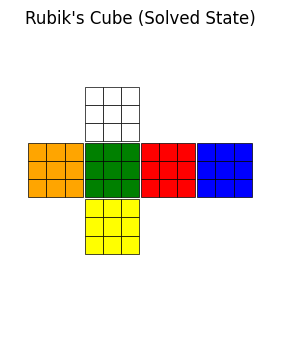

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

class CubeColorInline:
    def __init__(self):
        # Solved cube color state (same as before)
        self.color_state = np.array([
            [[ 'W', 'W', 'W'], ['W', 'W', 'W'], ['W', 'W', 'W']], # U (White)
            [[ 'O', 'O', 'O'], ['O', 'O', 'O'], ['O', 'O', 'O']], # L (Orange)
            [[ 'G', 'G', 'G'], ['G', 'G', 'G'], ['G', 'G', 'G']], # F (Green)
            [[ 'R', 'R', 'R'], ['R', 'R', 'R'], ['R', 'R', 'R']], # R (Red)
            [[ 'B', 'B', 'B'], ['B', 'B', 'B'], ['B', 'B', 'B']], # B (Blue)
            [[ 'Y', 'Y', 'Y'], ['Y', 'Y', 'Y'], ['Y', 'Y', 'Y']]  # D (Yellow)
        ])
        self.face_names = ['U', 'L', 'F', 'R', 'B', 'D']
        self.face_colors_mpl = { # Matplotlib color names
            'W': 'white', 'Y': 'yellow', 'G': 'green', 'B': 'blue', 'R': 'red', 'O': 'orange'
        }
        self.facelet_size = 0.1
        self.face_spacing = 0.01# Reduced face spacing


    def get_face_color_grid(self, face_name):
        """Returns color grid (same as before)"""
        face_index = self.face_names.index(face_name)
        face_grid = self.color_state[face_index].tolist()
        return face_grid

    def draw_face(self, ax, face_name, start_x, start_y):
        """Draws a single face using matplotlib."""
        face_index = self.face_names.index(face_name)
        face_grid = self.color_state[face_index]

        for row in range(3):
            for col in range(3):
                x = start_x + col * self.facelet_size
                y = start_y - row * self.facelet_size # Invert y for matplotlib coordinate system
                color_code = face_grid[row][col]
                fill_color = self.face_colors_mpl.get(color_code, 'gray')
                rect = patches.Rectangle((x, y - self.facelet_size), self.facelet_size, self.facelet_size,
                                         facecolor=fill_color, edgecolor='black', linewidth=0.5) # Thinner borders
                ax.add_patch(rect)


    def display(self):
        """Displays the cube inline in Jupyter using matplotlib."""
        fig, ax = plt.subplots(figsize=(5, 4)) # Halved figsize from (10, 8) to (5, 4)
        ax.set_aspect('equal') # Ensure square facelets
        ax.axis('off') # Turn off axes

        face_width_u = (self.facelet_size * 3 + self.face_spacing)
        face_width_lfrb = (self.facelet_size * 3 + self.face_spacing) * 4
        face_height = (self.facelet_size * 3 + self.face_spacing)

        # Center the whole cube layout horizontally and vertically
        start_x_centered = -face_width_lfrb*0.75 + face_width_u # Shift to center horizontally based on LFRB row width
        start_y_centered = face_height*2 # Shift to center vertically based on face height
        start_x, start_y = start_x_centered, start_y_centered

        # U face
        self.draw_face(ax, 'U', start_x + (self.facelet_size * 3 + self.face_spacing), start_y)

        # L, F, R, B faces (horizontally aligned)
        face_row_y = start_y - (self.facelet_size * 3 + self.face_spacing) # Adjust y for next row down
        self.draw_face(ax, 'L', start_x, face_row_y)
        self.draw_face(ax, 'F', start_x + (self.facelet_size * 3 + self.face_spacing), face_row_y)
        self.draw_face(ax, 'R', start_x + (self.facelet_size * 3 + self.face_spacing) * 2, face_row_y)
        self.draw_face(ax, 'B', start_x + (self.facelet_size * 3 + self.face_spacing) * 3, face_row_y)

        # D face
        self.draw_face(ax, 'D', start_x + (self.facelet_size * 3 + self.face_spacing), face_row_y - (self.facelet_size * 3 + self.face_spacing)) # Further down

        # Adjusted plot limits - recalculate based on the centered layout and smaller size
        xlim_max = face_width_lfrb / 2 + self.facelet_size # Extend slightly beyond right edge
        xlim_min = -face_width_lfrb / 2 - self.facelet_size # Extend slightly beyond left edge
        ylim_max = start_y_centered + self.facelet_size*3 # Extend slightly above top
        ylim_min = -face_height*2.5 # Extend sufficiently below bottom

        ax.set_xlim([xlim_min, xlim_max])
        ax.set_ylim([ylim_min, ylim_max])


        plt.title("Rubik's Cube (Solved State)") # Optional title
        plt.show() # Use plt.show() to display inline


# --- Example Usage for Jupyter Notebook ---
if __name__ == '__main__':
    inline_cube = CubeColorInline()
    inline_cube.display()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
from pythreejs import *
import numpy as np

class InteractiveRubiksCube:
    def __init__(self):
        # Scene setup with better colors
        self.scene = Scene(background="#303030")
        self.camera = PerspectiveCamera(
            position=[4, 4, 4], 
            up=[0, 1, 0],
            aspect=1, 
            fov=35
        )
        self.renderer = Renderer(
            scene=self.scene, 
            camera=self.camera, 
            antialias=True, 
            width=600, 
            height=600
        )

        # Cubelet properties with deeper colors
        self.cubelet_size = 0.95
        self.cubelet_spacing = 0.05
        self.face_colors = {
            'W': '#FFFFFF',  # White
            'Y': '#FFDD00',  # Yellow (slightly warmer)
            'G': '#009900',  # Green (deeper)
            'B': '#21acff',  # Blue
            'R': '#CC0000',  # Red (deeper)
            'O': '#FF6600',  # Orange
            'k': '#111111'   # Dark black
        }

        self.pieces = {}
        self._create_cube()

        # Better lighting
        self.scene.add(AmbientLight(color='#FFFFFF', intensity=0.7))
        for position in [[2, 2, 2], [-2, -2, 2], [2, -2, -2]]:
            directional_light = DirectionalLight(color='#FFFFFF', intensity=0.5)
            directional_light.position = position
            self.scene.add(directional_light)

        # Controls
        self.control = OrbitControls(controlling=self.camera)
        self.control.target = [0, 0, 0]
        self.control.autoRotate = True  # Add auto-rotation for better initial view
        self.control.autoRotateSpeed = 1.0
        self.renderer.controls = [self.control]

    def _create_cube(self):
        """Creates the 3D cube with correct face colors"""
        # Basic structure of the cube for reference
        # F = Front (facing viewer)
        # B = Back
        # U = Up
        # D = Down
        # L = Left
        # R = Right
        
        # Map piece ID to face colors - key is array index [i][j][k], value is color dict
        # This follows the standard Rubik's cube color scheme
        cube_color_map = {
            # Front layer (i=0)
            (0,0,0): {'U': 'W', 'L': 'O', 'F': 'G'},  # ULB corner 
            (0,0,1): {'U': 'W', 'F': 'G'},            # UB edge
            (0,0,2): {'U': 'W', 'R': 'R', 'F': 'G'},  # URB corner
            
            (0,1,0): {'F': 'G', 'L': 'O'},            # UL edge
            (0,1,1): {'F': 'G'},                      # U center
            (0,1,2): {'F': 'G', 'R': 'R'},            # UR edge
            
            (0,2,0): {'D': 'Y', 'L': 'O', 'F': 'G'},  # ULF corner
            (0,2,1): {'D': 'Y', 'F': 'G'},            # UF edge
            (0,2,2): {'D': 'Y', 'R': 'R', 'F': 'G'},  # URF corner
            
            # Middle layer (i=1)
            (1,0,0): {'L': 'O', 'U': 'W'},            # LB edge
            (1,0,1): {'U': 'W'},                      # B center 
            (1,0,2): {'R': 'R', 'U': 'W'},            # RB edge
            
            (1,1,0): {'L': 'O'},                      # L center
            (1,1,1): {},                              # Core (no color)
            (1,1,2): {'R': 'R'},                      # R center
            
            (1,2,0): {'L': 'O', 'D': 'Y'},            # LF edge
            (1,2,1): {'D': 'Y'},                      # F center
            (1,2,2): {'R': 'R', 'D': 'Y'},            # RF edge
            
            # Back layer (i=2)
            (2,0,0): {'U': 'W', 'L': 'O', 'B': 'B'},  # DLB corner
            (2,0,1): {'U': 'W', 'B': 'B'},            # DB edge
            (2,0,2): {'U': 'W', 'R': 'R', 'B': 'B'},  # DRB corner
            
            (2,1,0): {'B': 'B', 'L': 'O'},            # DL edge
            (2,1,1): {'B': 'B'},                      # D center
            (2,1,2): {'B': 'B', 'R': 'R'},            # DR edge
            
            (2,2,0): {'D': 'Y', 'L': 'O', 'B': 'B'},  # DLF corner
            (2,2,1): {'D': 'Y', 'B': 'B'},            # DF edge
            (2,2,2): {'D': 'Y', 'R': 'R', 'B': 'B'},  # DRF corner
        }

        # BoxGeometry material order (crucial for correct colors)
        # 0: Right (+X) face
        # 1: Left (-X) face
        # 2: Top (+Y) face
        # 3: Bottom (-Y) face
        # 4: Front (+Z) face
        # 5: Back (-Z) face
        face_indices = {
            'R': 0,  # Right 
            'L': 1,  # Left
            'U': 2,  # Up
            'D': 3,  # Down
            'F': 4,  # Front
            'B': 5   # Back
        }

        for i in range(3):
            for j in range(3):
                for k in range(3):
                    coords = (i, j, k)
                    piece_id = i*9 + j*3 + k + 1  # Convert to 1-27 piece ID for tracking
                    
                    if coords == (1, 1, 1):  # Skip center piece (optional)
                        continue
                        
                    # Get color configuration for this piece
                    piece_colors_config = cube_color_map.get(coords, {})
                    
                    # Create a list of 6 default materials
                    materials = ['k', 'k', 'k', 'k', 'k', 'k']  # All black by default
                    
                    # Apply colors based on configuration
                    for face, color in piece_colors_config.items():
                        materials[face_indices[face]] = color
                    
                    # Create materials for each face
                    box_materials = [
                        MeshStandardMaterial(
                            color=self.face_colors[color_code],
                            roughness=0.7,
                            metalness=0.1
                        ) for color_code in materials
                    ]
                    
                    # Create geometry
                    box_geometry = BoxGeometry(
                        width=self.cubelet_size, 
                        height=self.cubelet_size, 
                        depth=self.cubelet_size
                    )
                    
                    # Create mesh with correct positioning
                    box_mesh = Mesh(
                        geometry=box_geometry,
                        material=box_materials
                    )
                    
                    # Position needs to be calculated based on our coordinate system
                    # Convert from i,j,k (layer,row,col) to x,y,z
                    box_mesh.position = [
                        (k - 1) * (self.cubelet_size + self.cubelet_spacing),  # x = col - 1 (centered)
                        (1 - j) * (self.cubelet_size + self.cubelet_spacing),  # y = 1 - row (inverted)
                        (1 - i) * (self.cubelet_size + self.cubelet_spacing)   # z = 1 - layer (inverted) 
                    ]
                    
                    self.scene.add(box_mesh)
                    self.pieces[piece_id] = box_mesh

    def display(self):
        """Return the renderer widget for display in Jupyter."""
        return self.renderer
    
    def update_cube_state(self, cube_state):
        """
        Update the 3D cube based on the logical cube state.
        
        Args:
            cube_state: Cube class instance with current piece positions
        """
        # This method would be implemented to synchronize the visualization
        # with your Cube class instance
        pass


# --- Example Usage in Jupyter Notebook ---
if __name__ == '__main__':
    interactive_cube = InteractiveRubiksCube()
    display(interactive_cube.display())

Renderer(camera=PerspectiveCamera(fov=35.0, position=(4.0, 4.0, 4.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.…

In [ ]:
import numpy as np
from_pos = np.array([[1,2],[2,3]])
','.join(list(map(str, from_pos)))
print(np.where(from_pos%2 == 0))
print(np.argwhere(from_pos%2 == 0))

(array([0, 1], dtype=int64), array([1, 0], dtype=int64))
[[0 1]
 [1 0]]


In [ ]:
piece_initial_positions = np.array([
            [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
            [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
            [[19, 20, 21], [22, 23, 24], [25, 26, 27]]
        ])
piece_id = 2 #pos = (0,0,1)
print(list(zip(*np.where(piece_initial_positions == piece_id)))[0])
print(tuple(np.argwhere(piece_initial_positions == piece_id)[0]))

(0, 0, 1)
(0, 0, 1)


In [ ]:
import numpy as np
import networkx as nx
import json
import copy

class CubeBase:
    # Initial state definitions
    piece_initial_positions = np.array([
            [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
            [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
            [[19, 20, 21], [22, 23, 24], [25, 26, 27]]
    ])
    piece_initial_orientations = np.array([
            [['xyz', 'g', 'xyz'], ['g', 'F', 'g'], ['xyz', 'g', 'xyz']],
            [['g', 'U', 'g'], ['L', 'C', 'R'], ['g', 'D', 'g']],
            [['xyz', 'g', 'xyz'], ['g', 'B', 'g'], ['xyz', 'g', 'xyz']],
    ])

    # Initialize tables to None (will be loaded later)
    tables = None
    edge_distances = None
    corner_distances = None
    movements = None

    @classmethod
    def initialize(cls):
        """Initialize the static data needed for the cube operations"""
        if cls.tables is None:  # Only initialize once
            # First categorize the positions and IDs
            cls.edge_positions, cls.corner_positions = cls.categorize_positions_over_piece_types()
            cls.edge_ids, cls.corner_ids = cls.categorize_ids_over_piece_types()
            
            # Sort for consistent ordering
            cls.edge_positions.sort()
            cls.corner_positions.sort()
            cls.edge_ids.sort()
            cls.corner_ids.sort()
            
            # Load pre-computed tables
            cls.tables = cls._load_tables_from_json([
                'corner_position_distance_table.json',
                'edge_position_distance_table.json',
                'position_movement_table.json'
            ])
            cls.edge_distances = cls.tables["edge_distances"]
            cls.corner_distances = cls.tables["corner_distances"]
            cls.movements = cls.tables["movements"]

    @classmethod
    def categorize_ids_over_piece_types(cls):
        """Identifies edge and corner pieces based on orientation markers."""
        edge_ids = []
        corner_ids = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    piece_id = cls.piece_initial_positions[i, j, k]
                    orientation = cls.piece_initial_orientations[i, j, k]
                    # Skip center pieces
                    if piece_id in [5, 11, 13, 14, 15, 17, 23]:
                        continue
                    # Correct logic: 'g' is for edges, 'xyz' for corners
                    if orientation == 'g':
                        edge_ids.append(piece_id)
                    elif orientation == 'xyz':
                        corner_ids.append(piece_id)
        return edge_ids, corner_ids
    
    @classmethod
    def categorize_positions_over_piece_types(cls):
        """ Iterate through all positions in the cube and sort their positions into edges and corners """
        edge_positions = []
        corner_positions = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    # Skip center pieces
                    if cls.piece_initial_positions[i, j, k] in [5, 11, 13, 14, 15, 17, 23]:
                        continue
                    else:
                        if cls.piece_initial_orientations[i, j, k] == 'g':
                            edge_positions.append((i, j, k))
                        elif cls.piece_initial_orientations[i, j, k] == 'xyz':
                            corner_positions.append((i, j, k))
        return edge_positions, corner_positions

    @staticmethod
    def _load_tables_from_json(filenames: list):
        """
        Loads precomputed tables from JSON files and returns them in a dictionary.
        """
        tables = {
            "edge_distances": None,
            "corner_distances": None,
            "movements": None
        }
        
        for filename in filenames:
            try:
                with open(filename, 'r') as f:
                    serializable_table = json.load(f)
                    
                    # Determine which table type this file contains
                    if 'edge' in filename.lower() and 'distance' in filename.lower():
                        tables["edge_distances"] = {}
                        for pair_str, distance in serializable_table.items():
                            pos_tuple = tuple(eval(pair_str))
                            tables["edge_distances"][pos_tuple] = distance
                            
                    elif 'corner' in filename.lower() and 'distance' in filename.lower():
                        tables["corner_distances"] = {}
                        for pair_str, distance in serializable_table.items():
                            pos_tuple = tuple(eval(pair_str))
                            tables["corner_distances"][pos_tuple] = distance
                            
                    elif 'position' in filename.lower() and 'movement' in filename.lower():
                        tables["movements"] = {}
                        for move, position_movements in serializable_table.items():
                            movements = {}
                            for from_pos_str, to_pos_str in position_movements.items():
                                from_pos = tuple(eval(from_pos_str))
                                to_pos = tuple(eval(to_pos_str))
                                movements[from_pos] = to_pos
                            tables["movements"][move] = movements
                            
            except FileNotFoundError:
                print(f"FileNotFoundError: '{filename}' not found.")
            except json.JSONDecodeError:
                print(f"JSONDecodeError: Could not decode JSON from '{filename}'. File may be corrupted.")
            except Exception as e:
                print(f"Error loading '{filename}': {e}")
        
        # Log which tables were successfully loaded
        loaded_tables = [key for key, value in tables.items() if value is not None]
        if loaded_tables:
            print(f"Successfully loaded tables: {', '.join(loaded_tables)}")
        else:
            print("Warning: No tables were successfully loaded")
            
        return tables
    
class CubeTracker(CubeBase):
    def __init__(self):
        # Initialize the base class static data
        CubeBase.initialize()
        
        # Create copies of the initial state for this instance
        self.piece_current_positions = copy.deepcopy(CubeBase.piece_initial_positions)
        self.piece_current_orientations = copy.deepcopy(CubeBase.piece_initial_orientations)
    
        self.move_map = {
                'U': self._U, 'F': self._F, 'B': self._B, 'D': self._D, 'L': self._L, 'R': self._R,
                'u': self._u, 'f': self._f, 'b': self._b, 'd': self._d, 'l': self._l, 'r': self._r,
                'M': self._M, 'E': self._E, 'S': self._S, 'm': self._m, 'e': self._e, 's': self._s,
        }
        # The uppercase letters are the clockwise moves, and the lowercase letters are the counter-clockwise moves

        self.corner_piece_move_vs_orientation_map = {
            'U': lambda s: s[1] + s[0] + s[2],
            'u': lambda s: s[1] + s[0] + s[2],
            'D': lambda s: s[1] + s[0] + s[2],
            'd': lambda s: s[1] + s[0] + s[2],
            'L': lambda s: s[0] + s[2] + s[1],
            'l': lambda s: s[0] + s[2] + s[1],
            'R': lambda s: s[0] + s[2] + s[1],
            'r': lambda s: s[0] + s[2] + s[1],
            'F': lambda s: s[2] + s[1] + s[0],
            'f': lambda s: s[2] + s[1] + s[0],
            'B': lambda s: s[2] + s[1] + s[0],
            'b': lambda s: s[2] + s[1] + s[0],
        }

    def _rotate_slice(self, perspective, slice_idx, direction):
        """ Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction """
        def change_perspective(cube, perspective, direction):
            if perspective == 0: return cube
            else: return np.rot90(cube, k=direction, axes=(0, perspective))
            
        # Convert to the desired perspective, rotate the slice, then convert back
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, -1)
        self.piece_current_positions[slice_idx] = np.rot90(self.piece_current_positions[slice_idx], k=direction, axes=(0, 1))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, 1)

        self.piece_current_orientations = change_perspective(self.piece_current_orientations, perspective, -1)
        self.piece_current_orientations[slice_idx] = np.rot90(self.piece_current_orientations[slice_idx], k=direction, axes=(0, 1))
        self.piece_current_orientations = change_perspective(self.piece_current_orientations, perspective, 1)

    def _update_edge_orientations(self, move):
        """ Update the orientations of edges based on the move and new positions """
        # Create a copy of orientations before the move
        old_orientations = copy.deepcopy(self.piece_current_orientations)
        
        for edge in self.edge_positions:
            if edge in self.movements[move]:
                new_pos = self.movements[move][edge]
                piece_id = self.piece_current_positions[new_pos]  # Get the piece at the new position
                piece_initial_position = tuple(np.argwhere(self.piece_initial_positions == piece_id)[0])
                
                # Check if orientation should flip based on the move
                if self.edge_distances[(piece_initial_position, edge)] == self.edge_distances[(piece_initial_position, new_pos)]:
                    # No flip needed - maintain the orientation
                    i, j, k = edge
                    ni, nj, nk = new_pos
                    self.piece_current_orientations[ni, nj, nk] = old_orientations[i, j, k]
                else:
                    # Flip orientation (g -> b or b -> g)
                    i, j, k = edge
                    ni, nj, nk = new_pos
                    old_orientation = old_orientations[i, j, k]
                    new_orientation = 'b' if old_orientation == 'g' else 'g'
                    self.piece_current_orientations[ni, nj, nk] = new_orientation
    
    def _update_corner_orientations(self, move):
        """ Update the orientations of corners based on the move and new positions """
        # Create a copy of orientations before the move
        old_orientations = copy.deepcopy(self.piece_current_orientations)
        
        for corner in self.corner_positions:
            if corner in self.movements[move]:
                new_pos = self.movements[move][corner]
                i, j, k = corner
                ni, nj, nk = new_pos
                
                # Apply the orientation transformation based on the move
                current_orientation = old_orientations[i, j, k]
                new_orientation = self.corner_piece_move_vs_orientation_map[move](current_orientation)
                
                # Set the new orientation at the new position
                self.piece_current_orientations[ni, nj, nk] = new_orientation

    def _F(self): self._rotate_slice(perspective=0, slice_idx=0, direction=-1)
    def _f(self): self._rotate_slice(perspective=0, slice_idx=0, direction=1)
    def _M(self): self._rotate_slice(perspective=0, slice_idx=1, direction=-1)
    def _m(self): self._rotate_slice(perspective=0, slice_idx=1, direction=1)
    def _B(self): self._rotate_slice(perspective=0, slice_idx=2, direction=1)
    def _b(self): self._rotate_slice(perspective=0, slice_idx=2, direction=-1)

    def _U(self): self._rotate_slice(perspective=1, slice_idx=0, direction=-1)
    def _u(self): self._rotate_slice(perspective=1, slice_idx=0, direction=1)
    def _E(self): self._rotate_slice(perspective=1, slice_idx=1, direction=-1)
    def _e(self): self._rotate_slice(perspective=1, slice_idx=1, direction=1)
    def _D(self): self._rotate_slice(perspective=1, slice_idx=2, direction=1)
    def _d(self): self._rotate_slice(perspective=1, slice_idx=2, direction=-1)

    def _L(self): self._rotate_slice(perspective=2, slice_idx=0, direction=-1)
    def _l(self): self._rotate_slice(perspective=2, slice_idx=0, direction=1)
    def _S(self): self._rotate_slice(perspective=2, slice_idx=1, direction=-1)
    def _s(self): self._rotate_slice(perspective=2, slice_idx=1, direction=1)
    def _R(self): self._rotate_slice(perspective=2, slice_idx=2, direction=1)
    def _r(self): self._rotate_slice(perspective=2, slice_idx=2, direction=-1)

    def _get_position_of_piece(self, piece_id):
        """Returns the current position of a piece given its ID."""
        positions = np.where(self.piece_current_positions == piece_id)
        if len(positions[0]) > 0:
            return (positions[0][0], positions[1][0], positions[2][0])
        return None  # Piece ID not found

    def _get_piece_at_position(self, position):
        """Returns the piece ID at a given position (i, j, k)."""
        i, j, k = position
        return self.piece_current_positions[i, j, k]
    
    def _get_orientation_of_piece(self, piece_id):
        """Returns the orientation of a piece given its ID."""
        pos = self._get_position_of_piece(piece_id)
        if pos:
            i, j, k = pos
            return self.piece_current_orientations[i, j, k]
        return None

    def apply_moves(self, move_sequence):
        """Apply a sequence of moves to the cube."""
        if not isinstance(move_sequence, (list, str)):
            raise ValueError("argument to apply_moves must be a list or a string of valid moves")

        if isinstance(move_sequence, str):
            move_sequence = list(move_sequence)  # Convert string to list

        for index, move in enumerate(move_sequence):
            if move in self.move_map:
                # First make the move
                self.move_map[move]()
                
                # Then update orientations based on the new positions
                self._update_edge_orientations(move)
                self._update_corner_orientations(move)
            else:
                raise ValueError(f"Invalid move: '{move}' at index {index}")
            
c = Cube()

In [ ]:
import numpy as np
import networkx as nx
import json
import copy

class Cube:
    def __init__(self):
        # The PIECES are counted from Left-to-Right(axis=2), Top-to-Bottom (axis=1), and Front-to-Back (axis=0), in that order. The fourteenth piece is the invisible and irrelevant center-most piece of the cube
        self.piece_initial_positions = np.array([
            [[1 , 2 , 3 ], [4 , 5 , 6 ], [7 , 8 , 9 ]],
            [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
            [[19, 20, 21], [22, 23, 24], [25, 26, 27]]
        ])

        # This is the intial state of the cube, which is the solved state
        # Notice that only the corners are marked by 'xyz', and only the edges are marked by 'g' ('g' for good, other possible value is 'b' for bad)
        # Here x stands for the x-axis, y for y-axis and z for z-axis. The string means that the piece's axes are aligned with x, y and z axes of the cube in that order
        # g stands for "good", which is one of the two possible orientations of an edge piece at any given position, and other one is b, which stands for "bad"
        # The center pieces are not marked, as they always remain the same

        self.piece_initial_orientations = np.array([
            [['xyz', 'g', 'xyz'], ['g', 'F', 'g'], ['xyz', 'g', 'xyz']],
            [['g', 'U', 'g'], ['L', 'C', 'R'], ['g', 'D', 'g']],
            [['xyz', 'g', 'xyz'], ['g', 'B', 'g'], ['xyz', 'g', 'xyz']],
        ])

        self.piece_current_positions = copy.deepcopy(self.piece_initial_positions)
        self.piece_current_orientations = copy.deepcopy(self.piece_initial_orientations)

        # Call the piece-categorizing methods and store the results          
        self.edge_positions, self.corner_positions = self.categorize_positions_over_piece_types()
        self.edge_ids, self.corner_ids = self.categorize_ids_over_piece_types()

        # Sort positions and ids for consistent ordering
        self.edge_positions.sort()
        self.corner_positions.sort()
        self.edge_ids.sort()
        self.corner_ids.sort()

        self.move_map = {
            'U': self._U, 'F': self._F, 'B': self._B, 'D': self._D, 'L': self._L, 'R': self._R,
            'u': self._u, 'f': self._f, 'b': self._b, 'd': self._d, 'l': self._l, 'r': self._r,
            'M': self._M, 'E': self._E, 'S': self._S, 'm': self._m, 'e': self._e, 's': self._s,
        }
        # The uppercase letters are the clockwise moves, and the lowercase letters are the counter-clockwise moves

        self.corner_piece_move_vs_orientation_map = {
            'U': lambda s: s[1] + s[0] + s[2],
            'u': lambda s: s[1] + s[0] + s[2],
            'D': lambda s: s[1] + s[0] + s[2],
            'd': lambda s: s[1] + s[0] + s[2],
            'L': lambda s: s[0] + s[2] + s[1],
            'l': lambda s: s[0] + s[2] + s[1],
            'R': lambda s: s[0] + s[2] + s[1],
            'r': lambda s: s[0] + s[2] + s[1],
            'F': lambda s: s[2] + s[1] + s[0],
            'f': lambda s: s[2] + s[1] + s[0],
            'B': lambda s: s[2] + s[1] + s[0],
            'b': lambda s: s[2] + s[1] + s[0],
        }
        self.tables = self._load_tables_from_json([
            'corner_position_distance_table.json',
            'edge_position_distance_table.json',
            'position_movement_table.json'
        ])
        self.edge_distances = self.tables["edge_distances"]
        self.corner_distances = self.tables["corner_distances"]
        self.movements = self.tables["movements"]

    def categorize_ids_over_piece_types(self):
        """Identifies edge and corner pieces based on orientation markers."""
        edge_ids = []
        corner_ids = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    piece_id = self.piece_initial_positions[i, j, k]
                    orientation = self.piece_initial_orientations[i, j, k]
                    if orientation == 'g':  # corner
                        edge_ids.append(piece_id)
                    else:
                        corner_ids.append(piece_id)
        return edge_ids, corner_ids
    
    def categorize_positions_over_piece_types(self):
        """ Iterate through all positions in the cube and sort their positions into edges and corners """
        edge_positions = []
        corner_positions = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_positions[i, j, k] in [5, 11, 13, 14, 15, 17, 23]:
                        continue
                    else:
                        if self.piece_current_orientations[i, j, k] != 'g':
                            corner_positions.append((i, j, k))
                        else:
                            edge_positions.append((i, j, k))
        return edge_positions, corner_positions

    def _load_tables_from_json(self, filenames: list):
        """
        Loads precomputed tables from JSON files and returns them in a dictionary.

        Args:
            filenames: List of JSON filenames containing the precomputed tables

        Returns:
            dict: A dictionary containing loaded tables, with keys:
                "edge_distances", "corner_distances", "movements".
                Values are the loaded tables, or None if loading failed for a table type.
        """
        tables = {
            "edge_distances": None,
            "corner_distances": None,
            "movements": None
        }
        
        for filename in filenames:
            try:
                with open(filename, 'r') as f:
                    serializable_table = json.load(f)
                    
                    # Determine which table type this file contains
                    if 'edge' in filename.lower() and 'distance' in filename.lower():
                        tables["edge_distances"] = {}
                        for pair_str, distance in serializable_table.items():
                            pos_tuple = tuple(eval(pair_str))  # Consistent parsing using eval
                            tables["edge_distances"][pos_tuple] = distance
                            
                    elif 'corner' in filename.lower() and 'distance' in filename.lower():
                        tables["corner_distances"] = {}
                        for pair_str, distance in serializable_table.items():
                            pos_tuple = tuple(eval(pair_str))  # Consistent parsing
                            tables["corner_distances"][pos_tuple] = distance
                            
                    elif 'position' in filename.lower() and 'movement' in filename.lower():
                        tables["movements"] = {}
                        for move, position_movements in serializable_table.items():
                            movements = {}
                            for from_pos_str, to_pos_str in position_movements.items():
                                from_pos = tuple(eval(from_pos_str))
                                to_pos = tuple(eval(to_pos_str))
                                movements[from_pos] = to_pos
                            tables["movements"][move] = movements
                            
            except FileNotFoundError:
                print(f"FileNotFoundError: '{filename}' not found.")
            except json.JSONDecodeError:
                print(f"JSONDecodeError: Could not decode JSON from '{filename}'. File may be corrupted.")
            except Exception as e:
                print(f"Error loading '{filename}': {e}")
        
        # Log which tables were successfully loaded
        loaded_tables = [key for key, value in tables.items() if value is not None]
        if loaded_tables:
            print(f"Successfully loaded tables: {', '.join(loaded_tables)}")
        else:
            print("Warning: No tables were successfully loaded")
            
        return tables
    
    def _rotate_slice(self, perspective, slice_idx, direction):
        """ Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction """
        def change_perspective(cube, perspective, direction):
            if perspective == 0: return cube
            else: return np.rot90(cube, k=direction, axes=(0, perspective))
        # Convert to the desired perspective, rotate the slice, then convert back
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, -1)
        self.piece_current_positions[slice_idx] = np.rot90(self.piece_current_positions[slice_idx], k=direction, axes=(0, 1))
        self.piece_current_positions = change_perspective(self.piece_current_positions, perspective, 1)

        self.piece_current_orientations = change_perspective(self.piece_current_orientations, perspective, -1)
        self.piece_current_orientations[slice_idx] = np.rot90(self.piece_current_orientations[slice_idx], k=direction, axes=(0, 1))
        self.piece_current_orientations = change_perspective(self.piece_current_orientations, perspective, 1)

    def _update_edge_orientations(self, move):
        """ Update the orientations of edges based on the move made """
        for edge in self.edge_positions:
            if edge in self.movements[move].keys():
                piece_id = self.piece_current_positions[edge]
                piece_initial_position = list(zip(*np.where(self.piece_initial_positions == piece_id)))[0]
                if self.edge_distances[(piece_initial_position, edge)] == self.edge_distances[(piece_initial_position, self.movements[move][edge])]:
                    next_orientation = ['g', 'b']
                    next_orientation.remove(self.piece_current_orientations[edge])
                    self.piece_current_orientations[edge] = next_orientation[0]
    
    def _update_corner_orientations(self, move):
        """ Update the orientations of corners based on the move made """
        for corner in self.corner_positions:
            if corner in self.movements[move].keys():
                current_orientation = self.piece_current_orientations[corner]
                self.piece_current_orientations[corner] = self.corner_piece_move_vs_orientation_map[move](current_orientation)

    def _F(self): self._rotate_slice(perspective=0, slice_idx=0, direction=-1)
    def _f(self): self._rotate_slice(perspective=0, slice_idx=0, direction=1)
    def _M(self): self._rotate_slice(perspective=0, slice_idx=1, direction=-1)
    def _m(self): self._rotate_slice(perspective=0, slice_idx=1, direction=1)
    def _B(self): self._rotate_slice(perspective=0, slice_idx=2, direction=1)
    def _b(self): self._rotate_slice(perspective=0, slice_idx=2, direction=-1)

    def _U(self): self._rotate_slice(perspective=1, slice_idx=0, direction=-1)
    def _u(self): self._rotate_slice(perspective=1, slice_idx=0, direction=1)
    def _E(self): self._rotate_slice(perspective=1, slice_idx=1, direction=-1)
    def _e(self): self._rotate_slice(perspective=1, slice_idx=1, direction=1)
    def _D(self): self._rotate_slice(perspective=1, slice_idx=2, direction=1)
    def _d(self): self._rotate_slice(perspective=1, slice_idx=2, direction=-1)

    def _L(self): self._rotate_slice(perspective=2, slice_idx=0, direction=-1)
    def _l(self): self._rotate_slice(perspective=2, slice_idx=0, direction=1)
    def _S(self): self._rotate_slice(perspective=2, slice_idx=1, direction=-1)
    def _s(self): self._rotate_slice(perspective=2, slice_idx=1, direction=1)
    def _R(self): self._rotate_slice(perspective=2, slice_idx=2, direction=1)
    def _r(self): self._rotate_slice(perspective=2, slice_idx=2, direction=-1)

    def _get_position_of_piece(self, piece_id):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_positions[i, j, k] == piece_id:
                        return (i, j, k)
        return None # Piece ID not found (should not happen in a valid cube state)

    def _get_piece_at_position(self, position):
        """Returns the piece ID at a given position (i, j, k)."""
        i, j, k = position
        return self.piece_current_positions[i, j, k]
    
    def _get_orientation_of_piece(self, piece_id):
        """Returns the orientation of a piece given its ID."""
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_positions[i, j, k] == piece_id:
                        return self.piece_current_orientations[i, j, k]
        return None

    def apply_moves(self, move_sequence):
        if not isinstance(move_sequence, (list, str)):
            raise ValueError("argument to apply_moves must be a list or a string of valid moves")

        if isinstance(move_sequence, str):
            move_sequence = list(move_sequence) # Convert string to list for consistent iteration

        for index, move in enumerate(move_sequence): # More idiomatic and readable way to get index in loop
            if move in self.move_map:
                self._update_corner_orientations(move)
                self._update_edge_orientations(move)
                self.move_map[move]()
            else:
                raise ValueError(f"Invalid move: '{move}' at index {index}") # More readable error message
    


In [ ]:
import numpy as np
import psutil
import os
import gc  # Replace with your actual module name

def format_bytes(size):
    """Convert bytes to human-readable format (KB, MB)"""
    power = 2**10  # 1024
    n = 0
    power_labels = {0: 'B', 1: 'KB', 2: 'MB', 3: 'GB'}
    while size > power:
        size /= power
        n += 1
    return f"{size:.2f} {power_labels[n]}"

def measure_memory_usage(label=""):
    """Get current memory usage of the Python process"""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    if label:
        print(f"{label}: {format_bytes(memory_info.rss)}")
    return memory_info.rss  # Return in bytes

# Force garbage collection to get a clean baseline
gc.collect()

# Measure initial memory
initial_memory = measure_memory_usage("Initial memory usage")

# Create 100 CubeTracker instances
cube_instances = []
for i in range(100):
    cube = Cube()
    # Apply a few moves to each one to ensure they're fully initialized
    moves = "RURURU" if i % 2 == 0 else "LFLFLF"
    cube.apply_moves(moves)
    cube_instances.append(cube)
    
    # Print progress every 10 instances
    if (i+1) % 10 == 0:
        current_memory = measure_memory_usage(f"After {i+1} instances")

# Force garbage collection again
gc.collect()

# Measure final memory
final_memory = measure_memory_usage("Final memory usage")

# Calculate per-instance memory usage
total_increase = final_memory - initial_memory
per_instance = total_increase / 100

print(f"\nTotal memory increase: {format_bytes(total_increase)}")
print(f"Average memory per instance: {format_bytes(per_instance)}")

# Verify that we're not duplicating the tables
first_instance_tables_id = id(cube_instances[0].tables)
print("\nChecking if tables are properly shared across instances:")
all_same = True
for i in range(1, 100):
    if id(cube_instances[i].tables) != first_instance_tables_id:
        print(f"  Instance {i} has different tables object!")
        all_same = False

if all_same:
    print("  ✓ All instances share the same tables object (good!)")

Initial memory usage: 90.21 MB
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
After 10 instances: 90.57 MB
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Successfully loaded tables: edge_distances, corner_distances, movements
Succ

In [ ]:
from collections import defaultdict

# Method 1: Direct declaration
nested_dict = {
    'key1': {'nested_key1': 'value1', 'nested_key2': 'value2'},
    'key2': {'nested_key3': 'value3', 'nested_key4': 'value4'}
}

# Method 2: Building incrementally
nested_dict2 = {}
nested_dict2['key1'] = {}
nested_dict2['key1']['nested_key1'] = 'value1'
nested_dict2['key1']['nested_key2'] = 'value2'

# Method 3: Using defaultdict for automatic dictionary creation
auto_nested = defaultdict(dict)
auto_nested['key1']['nested_key1'] = 'value1'  # No need to initialize inner dict

# Method 4: For arbitrary nesting depth
def nested_dict():
    return defaultdict(nested_dict)

deep_nested = nested_dict()
deep_nested['level1']['level2']['level3']['level4'] = 'deep value'

print(nested_dict)

In [ ]:
a = [1,2]
b = [3,4]
a.extend(b)  # Extends list a with elements from list b
print(a)

[1, 2, 3, 4]


In [19]:
isolated_move_sequences = {
    "Orange": ["R", "F'", "U"],
    "Blue": ["L'", "B'"],
    "Red": ["B'", "U"],
    "Green": ["D", "F'", "F'"] # Or ["D", "F2"] if you prefer to use F2 notation
}
def get_freely_available_move(column_moves, depth, current_moves_in_branch):
    """
    Returns the freely available move from a column's move sequence for a given depth.

    Args:
        column_moves: List of moves in the isolated sequence for the column.
        depth: Current recursion depth (0-indexed).
        current_moves_in_branch: List of moves already made in the current recursive branch.

    Returns:
        str or None: The freely available move or None if no move is available at this depth.
    """
    if depth >= len(column_moves):
        return None  # No more moves in this sequence for this depth or deeper

    move_to_consider = column_moves[depth] # Get the move at the current depth index

    # Check if this move has already been used at a shallower depth in the current branch
    # (In your description, "freely available move" meant "not used in shallower levels in the SAME branch")
    if depth < len(current_moves_in_branch) and current_moves_in_branch[depth] is not None:
        # This depth already has a move assigned in the current branch, should not happen in correct algorithm flow
        return None # Or raise an error, depending on how you want to handle unexpected situations

    # In the current logic, a move at 'depth' is freely available if we just need to consider the move at this index in the sequence
    return move_to_consider


# --- Example Usage ---
if __name__ == "__main__": # Keep example usage within this block
    # Example Usage:
    orange_moves = isolated_move_sequences["Orange"]
    current_branch_moves = []

    move_depth_0 = get_freely_available_move(orange_moves, 0, current_branch_moves)
    print(f"Freely available move at depth 0 for Orange: {move_depth_0}") # Expected: R

    current_branch_moves = [move_depth_0] # Simulate choosing 'R' at depth 0
    move_depth_1 = get_freely_available_move(orange_moves, 1, current_branch_moves)
    print(f"Freely available move at depth 1 for Orange: {move_depth_1}") # Expected: F'

    current_branch_moves = [move_depth_0, move_depth_1] # Simulate choosing 'F'' at depth 1
    move_depth_2 = get_freely_available_move(orange_moves, 2, current_branch_moves)
    print(f"Freely available move at depth 2 for Orange: {move_depth_2}") # Expected: U

    current_branch_moves = [move_depth_0, move_depth_1, move_depth_2] # Simulate choosing 'U' at depth 2
    move_depth_3 = get_freely_available_move(orange_moves, 3, current_branch_moves)
    print(f"Freely available move at depth 3 for Orange: {move_depth_3}") # Expected: None (sequence exhausted)

Freely available move at depth 0 for Orange: R
Freely available move at depth 1 for Orange: F'
Freely available move at depth 2 for Orange: U
Freely available move at depth 3 for Orange: None


In [9]:
from collections import defaultdict

# Create a nested defaultdict: each new key creates another defaultdict that defaults to a list for missing keys.
nested_dd = defaultdict(lambda: defaultdict(list))

# Add some items
nested_dd["group1"]["red"].append("apple")
nested_dd["group1"]["red"].append("banana")
nested_dd["group2"]["green"].append("avocado")
print(nested_dd["group1"]["red"][1])

banana


In [12]:
from collections import defaultdict

# Define a factory function that returns a list containing one empty list
def list_of_lists():
    return [[]]

# Create the nested defaultdict structure
data_structure = defaultdict(lambda: defaultdict(list_of_lists))

# Example usage:
data_structure["outer_key"]["inner_key"].append(["value1", "value2"])
data_structure["outer_key"]["inner_key"].append(["value3", "value4"])

# Access values
print(data_structure["outer_key"]["inner_key"])  # [[], ["value1", "value2"], ["value3", "value4"]]

# Default behavior when accessing new keys
print(data_structure["new_outer"]["new_inner"])  # [[]]
print(data_structure.items())

[[], ['value1', 'value2'], ['value3', 'value4']]
[[]]
dict_items([('outer_key', defaultdict(<function list_of_lists at 0x000001EE861480E0>, {'inner_key': [[], ['value1', 'value2'], ['value3', 'value4']]})), ('new_outer', defaultdict(<function list_of_lists at 0x000001EE861480E0>, {'new_inner': [[]]}))])


In [ ]:
import json
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from collections import deque, defaultdict
from Simulators.cube_model_positions_only import Cube
import copy
import numpy as np
def generate_move_table():
    """
    Generates a table mapping each move to the positions it affects and their new positions.

    Returns:
        dict: A dictionary where keys are move names and values are dictionaries
              mapping initial positions to final positions after the move.
    """
    cube = Cube()  # Create a fresh cube in solved_cube state
    movement_table = {}

    # Positions that are not the center and thus their pieces' positions are tracked
    tracked_positions = [(i,j,k) for i in range(0,3) for j in range(0,3) for k in range(0,3)]

    # For each possible move
    for move in cube.move_map.keys():
        # Get fresh cube for each move calculation
        test_cube = Cube()

        # Record initial piece IDs at each tracked position
        initial_piece_ids = {}
        for pos in tracked_positions:
            initial_piece_ids[pos] = test_cube._get_piece_at_position(pos)

        # Apply the move
        test_cube.apply_moves(move)

        # Record final positions based on moved piece IDs
        movements = {}
        for initial_pos in tracked_positions:
            piece_id_to_track = initial_piece_ids[initial_pos]
            final_pos = test_cube._get_position_of_piece(piece_id_to_track) # Find where that piece ended up
            if initial_pos != final_pos:
                movements[initial_pos] = final_pos

        # Store in table
        movement_table[move] = movements

    # Save to file
    with open('../Precomputed_Tables/position_movement_table.json', 'w') as f:
        # Convert tuple positions to strings for JSON serialization
        serializable_table = {}
        for move, position_movements in movement_table.items():
            serializable_movements = {}
            for from_pos, to_pos in position_movements.items():
                from_pos_str = ','.join(map(str, from_pos))
                to_pos_str = ','.join(map(str, to_pos))
                serializable_movements[from_pos_str] = to_pos_str
            serializable_table[move] = serializable_movements

        json.dump(serializable_table, f, indent=2)
generate_move_table()
def calculate_distance_table(piece_type, filename:str):
    """
    Builds a position graph for the piece type, then BFSes in that position graph
    from the start position to the target position. This ignores the rest of the puzzle.
    The distance table is keyed by positions, not piece IDs.
    """
    solved_cube = Cube()
    all_moves = list(solved_cube.move_map.keys())
    core_moves = copy.deepcopy(all_moves)
    for move in ['M', 'E', 'S', 'm', 'e', 's']:
        core_moves.remove(move)
    valid_positions = solved_cube.edge_positions if piece_type == "edge" else solved_cube.corner_positions

    #load the position_movement_table created in the previous cell:
    try:
        filename_1 = "../Precomputed_Tables/position_movement_table.json"
        with open(filename_1, 'r') as f:
            serializable_table:dict = json.load(f)
    except Exception as e:
        print(f"Failed to load {filename_1}: {e}")

    # serialize the loaded position_movement json table with the signature -
    # {position: {move: new_position}}
    movement_table = defaultdict(dict)
    for move, position_movements in serializable_table.items():
        for from_pos_str, to_pos_str in position_movements.items():
            from_pos = tuple(eval(from_pos_str))
            to_pos = tuple(eval(to_pos_str))
            movement_table[from_pos][move] = to_pos

    distance_table = {}
    for start_pos in valid_positions: # Iterate over positions, not piece_ids
        for target_pos in valid_positions:
            if start_pos == target_pos:
                distance_table[(start_pos, target_pos)] = 0
                continue

            if (target_pos, start_pos) in distance_table: #symmetry optimization
                distance_table[(start_pos, target_pos)] = distance_table[(target_pos, start_pos)]
                continue

            # BFS in the position graph from start_pos to target_pos
            visited = set([start_pos])
            queue = deque([(start_pos, 0)])
            found_distance = -1

            while queue:
                current_pos, dist = queue.popleft()
                if current_pos == target_pos:
                    found_distance = dist
                    break
                # Explore all possible moves from current_pos in the graph
                for move in movement_table[current_pos]:
                    if move not in core_moves:
                        continue
                    else:
                        next_pos = movement_table[current_pos][move]
                        if next_pos not in visited:
                            visited.add(next_pos)
                            queue.append((next_pos, dist + 1))

            distance_table[(start_pos, target_pos)] = found_distance

    serializable_table = {}
    for pos_pair, dist in distance_table.items(): # Key is now position pair
        serializable_table[str(pos_pair)] = dist
    with open(filename, 'w') as f:
        json.dump(serializable_table, f, indent=2)
calculate_distance_table("edge", "../Precomputed_Tables/edge_position_distance_table.json")
calculate_distance_table("corner", "../Precomputed_Tables/corner_position_distance_table.json")
def calculate_minimum_paths(filename:str, piece_type:str):
    """
    Builds a minimum-path dictionary from every piece of the given piece_type to every other piece of that type and stores it in the given json file.
    Args:
        filename: The name of the json file for the table to be stored in
        piece_type: `'edge'` or `'corner'`
    """

    # Retrieve the serializable distance table of the corresponding piece type:
    if piece_type == 'edge':
        filename_1 = "../Precomputed_Tables/edge_position_distance_table.json"
    else:
        filename_1 = "../Precomputed_Tables/corner_position_distance_table.json"
    try:
        with open(filename_1, "r") as f:
            serializable_table:dict = json.load(f)
    except Exception as e:
        print(f"Error loading file {filename_1}: {e}")

    # Serialize the loaded distance table with the signature - 
    # {init_position: {distance: [final_positions]}}
    distance_table = defaultdict(lambda: defaultdict(list))
    for pos_pair, distance in serializable_table.items():
        pos_pair_tuple = tuple(eval(pos_pair))
        init_pos = pos_pair_tuple[0]
        final_pos = pos_pair_tuple[1]
        distance_table[init_pos][distance].append(final_pos)

    #load the position_movement_table created in a previous cell:
    try:
        filename_2 = "../Precomputed_Tables/position_movement_table.json"
        with open(filename_2, 'r') as f:
            serializable_table:dict = json.load(f)
    except Exception as e:
        print(f"Failed to load {filename_2}: {e}")

    # serialize the loaded movement json table with the signature -
    # {position: {new_position: [moves]}}
    movement_table = defaultdict(lambda: defaultdict(list))
    for move, position_movements in serializable_table.items():
        for from_pos_str, to_pos_str in position_movements.items():
            from_pos = tuple(eval(from_pos_str))
            to_pos = tuple(eval(to_pos_str))
            movement_table[from_pos][to_pos].append(move)
    
    # Create the datastructure to store the final_output (min_paths):
    def list_of_lists():
        return [[]]
    min_paths = defaultdict(lambda: defaultdict(list_of_lists))

    # Begin building paths:
calculate_minimum_paths("../Precomputed_Tables/edge_min_path_table.json", "edge")
calculate_minimum_paths("../Precomputed_Tables/corner_min_path_table.json", "corner")

In [12]:
a = {1,2,3}
a = list(a)
a.sort()
a

[1, 2, 3]

In [15]:
from collections import deque
s = [1, 2, 3]
d = deque(s)
d.popleft()
d

deque([2, 3])

In [19]:
x = {'a': 1, 'b': 2, 'c': 3}
list(x.keys())[0]

'a'

In [ ]:
# Basic usage of map() function
# Example 1: Apply a built-in function to each item in a list
numbers = [1, 2, 3, 4, 5]
squared = list(map(lambda x: x**2, numbers))
print("Squared numbers:", squared)  # Output: [1, 4, 9, 16, 25]

# Example 2: Convert strings to integers
str_nums = ["1", "2", "3", "4", "5"]
int_nums = list(map(int, str_nums))
print("Converted to integers:", int_nums)  # Output: [1, 2, 3, 4, 5]

# Example 3: Using a custom function with map
def fahrenheit_to_celsius(f):
    return (f - 32) * 5/9

temperatures_f = [32, 68, 86, 104, 212]
temperatures_c = list(map(fahrenheit_to_celsius, temperatures_f))
print("Temperatures in Celsius:", [round(c, 1) for c in temperatures_c])  # Output: [0.0, 20.0, 30.0, 40.0, 100.0]

# Example 4: Using map with multiple iterables
first_list = [1, 2, 3]
second_list = [4, 5, 6]
sums = list(map(lambda x, y: x + y, first_list, second_list))
print("Element-wise sums:", sums)  # Output: [5, 7, 9]

# Example 5: Combining map with filter
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
even_squares = list(map(lambda x: x**2, filter(lambda x: x % 2 == 0, numbers)))
print("Squares of even numbers:", even_squares)  # Output: [4, 16, 36, 64, 100]

# Example 6: Processing strings with map
names = ["alice", "bob", "charlie"]
capitalized = list(map(str.capitalize, names))
print("Capitalized names:", capitalized)  # Output: ['Alice', 'Bob', 'Charlie']

In [ ]:
# Method 1: Using zip() (most Pythonic approach)
list1 = ['a', 'b', 'c']
list2 = [1, 2, 3]

# Create pairs as tuples
pairs_tuples = list(zip(list1, list2))
print("Pairs as tuples:", pairs_tuples)  # [('a', 1), ('b', 2), ('c', 3)]

# Create pairs as lists
pairs_lists = [list(item) for item in zip(list1, list2)]
print("Pairs as lists:", pairs_lists)  # [['a', 1], ['b', 2], ['c', 3]]

# Create a dictionary (if list1 has unique elements)
pairs_dict = dict(zip(list1, list2))
print("As dictionary:", pairs_dict)  # {'a': 1, 'b': 2, 'c': 3}

# Method 2: Using list comprehension with indices
pairs_by_index = [(list1[i], list2[i]) for i in range(min(len(list1), len(list2)))]
print("Using list comprehension:", pairs_by_index)

# Method 3: Using a for loop (most verbose)
manual_pairs = []
for i in range(min(len(list1), len(list2))):
    manual_pairs.append((list1[i], list2[i]))
print("Using for loop:", manual_pairs)

In [2]:
with 'w' as f:
    print(f)

TypeError: 'str' object does not support the context manager protocol

In [1]:
import json
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from collections import deque, defaultdict
from Simulators.cube_model_positions_only import Cube
import copy
import numpy as np

In [ ]:
def calculate_minimum_paths(filename:str, piece_type:str):
    """
    Builds a minimum-path dictionary from every piece of the given piece_type to every other piece of that type and stores it in the given json file.
    Args:
        filename: The name of the json file for the table to be stored in
        piece_type: `'edge'` or `'corner'`
    """
    cube = Cube()
    # Retrieve the serializable distance table of the corresponding piece type:
    if piece_type == 'edge':
        filename_1 = "../Precomputed_Tables/edge_position_distance_table.json"
    else:
        filename_1 = "../Precomputed_Tables/corner_position_distance_table.json"
    try:
        with open(filename_1, "r") as f:
            serializable_table:dict = json.load(f)
    except Exception as e:
        print(f"Error loading file {filename_1}: {e}")

    # Serialize the loaded distance table with the three signatures - 
    # {init_position(tuple): {distance(int): [final_position(tuple), ...]}}
    # {distance(int): {initial_position(tuple): [final_position(tuple), ...]}}
    # {init_position(tuple): {final_position(tuple): distance(int)}}
    distance_table_1 = defaultdict(lambda: defaultdict(list))
    distance_table_2 = defaultdict(lambda: defaultdict(list))
    distance_table_3 = defaultdict(dict)
    for pos_pair, distance in serializable_table.items():
        pos_pair_tuple = tuple(eval(pos_pair))
        init_pos = pos_pair_tuple[0]
        final_pos = pos_pair_tuple[1]
        distance_table_1[init_pos][distance].append(final_pos)
        distance_table_2[distance][init_pos].append(final_pos)
        distance_table_3[init_pos][final_pos] = distance

    print("distance_table_2", distance_table_2)

    #load the position_movement_table created in a previous cell:
    try:
        filename_2 = "../Precomputed_Tables/position_movement_table.json"
        with open(filename_2, 'r') as f:
            serializable_table:dict = json.load(f)
    except Exception as e:
        print(f"Failed to load {filename_2}: {e}")

    # serialize the loaded movement json table with the signature -
    # {position: {new_position: [moves]}}
    movement_table = defaultdict(lambda: defaultdict(list))
    for move, position_movements in serializable_table.items():
        for from_pos_str, to_pos_str in position_movements.items():
            from_pos = tuple(eval(from_pos_str))
            to_pos = tuple(eval(to_pos_str))
            movement_table[from_pos][to_pos].append(move)
    
    # Create the data structure to store the final_output (min_paths) with the signature - 
    # {path_length(int): {position(tuple): {new_position(tuple): [[move_sequence(str)], ...]}}}
    min_paths = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # Get possible distances list:
    possible_distances = []
    for position, distances in distance_table_1.items():
            possible_distances.extend(distances.keys())
    possible_distances = sorted(list(set(possible_distances)))
    possible_distances.pop(0)
    
 
    # Begin building paths:

    # build length-one paths:

    for a, b in distance_table_1.items():
        for c in b[1]:
            min_paths[1][a][c] = movement_table[a][c]

    
    zz = "----------"*9
    i = 0
    for current_distance in possible_distances:

        j = 0

        for init_pos, positions_for_dists in distance_table_1.items():
            final_positions = positions_for_dists[current_distance]

            if (current_distance-1) in min_paths.keys():

                k = 0
                
                for previous_level_final_pos, previous_level_paths in min_paths[current_distance-1][init_pos].items():

                    l = 0
            
                    for final_position in final_positions:

                        m = 0

                        if distance_table_3[previous_level_final_pos][final_position] == 1:
                            
                            for previous_level_path in previous_level_paths:

                                n = 0

                                for move in movement_table[previous_level_final_pos][final_position]:

                                    o = 0

                                    print("loop1:", i)
                                    print("loop2:", j)
                                    print("loop3:", k)
                                    print("loop4:", l)
                                    print("loop5:", m)
                                    print("loop6:", n)
                                    print("loop7:", o)
                                    print("current distance:", current_distance)
                                    print("init_pos:", init_pos)
                                    print("final_positions:", final_positions)
                                    print("final_position:", final_position)
                                    print("(current_distance-1)=", current_distance-1)
                                    print("previous_level_final_pos:", previous_level_final_pos)
                                    print("previous_level_paths:", previous_level_paths)
                                    print("distance_table_3[previous_level_final_pos][final_position]:", distance_table_3[previous_level_final_pos][final_position])
                                    print("movement_table[previous_level_final_pos][final_position]:", movement_table[previous_level_final_pos][final_position])
                                    print("move: ", move)

                                    print(zz)
                                    o+=1

                                print("loop6:", n)
                                print(zz)
                                print(zz)
                                n+=1
                        m += 1
                        print("loop5:", m)                        
                        print(zz)
                        print(zz)
                        print(zz)
                    l+=1
                    print("loop4:", l)
                    print(zz)
                    print(zz)
                    print(zz)
                    print(zz)
                k+=1
                print("loop3:", k)
                print(zz)
                print(zz)
                print(zz)
                print(zz)
                print(zz)
        j+=1
        print("loop2:", j)
        print(zz)
        print(zz)
        print(zz)
        print(zz)
        print(zz)
        print(zz)
    i+=1 
    print("loop1:", i)
    print(zz)
    print(zz)
    print(zz)
    print(zz)
    print(zz)
    print(zz)                          
    print(zz)
    #                               if move not in previous_level_path:
    #                                   min_paths[distance][init_pos][final_position].append(previous_level_path+move)
    
    # print(min_paths)
    
    # serializable_table = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    # for distance in min_paths.keys():
    #     for init_position in distance.keys():
    #         for final_position in init_position.keys():
    #             json_paths = ", ".join([path for path in min_paths[distance][init_position][final_position]])
    #             serializable_table[str(distance)][str(init_position)][str(final_position)] = json_paths
    # with open(filename, 'w') as f:
    #     json.dump(serializable_table, f, indent=2)

In [4]:
def calculate_minimum_paths(filename:str, piece_type:str):
    """
    Builds a minimum-path dictionary from every piece of the given piece_type to every other piece of that type and stores it in the given json file.
    Args:
        filename: The name of the json file for the table to be stored in
        piece_type: `'edge'` or `'corner'`
    """
    cube = Cube()
    # Retrieve the serializable distance table of the corresponding piece type:
    if piece_type == 'edge':
        filename_1 = "../Precomputed_Tables/edge_position_distance_table.json"
    else:
        filename_1 = "../Precomputed_Tables/corner_position_distance_table.json"
    try:
        with open(filename_1, "r") as f:
            serializable_table:dict = json.load(f)
    except Exception as e:
        print(f"Error loading file {filename_1}: {e}")

    # Serialize the loaded distance table with the three signatures - 
    # {init_position(tuple): {distance(int): [final_position(tuple), ...]}}
    # {distance(int): {initial_position(tuple): [final_position(tuple), ...]}}
    # {init_position(tuple): {final_position(tuple): distance(int)}}
    distance_table_1 = defaultdict(lambda: defaultdict(list))
    distance_table_2 = defaultdict(lambda: defaultdict(list))
    distance_table_3 = defaultdict(dict)
    for pos_pair, distance in serializable_table.items():
        pos_pair_tuple = tuple(eval(pos_pair))
        init_pos = pos_pair_tuple[0]
        final_pos = pos_pair_tuple[1]
        distance_table_1[init_pos][distance].append(final_pos)
        distance_table_2[distance][init_pos].append(final_pos)
        distance_table_3[init_pos][final_pos] = distance

    #load the position_movement_table created in a previous cell:
    try:
        filename_2 = "../Precomputed_Tables/position_movement_table.json"
        with open(filename_2, 'r') as f:
            serializable_table:dict = json.load(f)
    except Exception as e:
        print(f"Failed to load {filename_2}: {e}")

    # serialize the loaded movement json table with the signature -
    # {position: {new_position: [moves]}}
    movement_table = defaultdict(lambda: defaultdict(list))
    for move, position_movements in serializable_table.items():
        for from_pos_str, to_pos_str in position_movements.items():
            from_pos = tuple(eval(from_pos_str))
            to_pos = tuple(eval(to_pos_str))
            movement_table[from_pos][to_pos].append(move)
    
    # Create the data structure to store the final_output (min_paths) with the signature - 
    # {path_length(int): {position(tuple): {new_position(tuple): [[move_sequence(str)], ...]}}}
    min_paths = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # Get possible distances list:
    possible_distances = []
    for position, distances in distance_table_1.items():
            possible_distances.extend(distances.keys())
    possible_distances = sorted(list(set(possible_distances)))
    possible_distances.pop(0)
    
 
    # Begin building paths:

    # build length-zero paths:
    if piece_type == "edge":
        piece_positions = cube.edge_positions
    else:
        piece_positions = cube.corner_positions
    for piece_position in piece_positions:
        min_paths[0][piece_position][piece_position] = ['N']

    for current_distance in possible_distances:
        for init_pos, positions_for_dists in distance_table_1.items():
            final_positions = positions_for_dists[current_distance]
            if (current_distance-1) in min_paths.keys():
                for previous_level_final_pos, previous_level_paths in min_paths[current_distance-1][init_pos].items():
                    for final_position in final_positions:
                        if distance_table_3[previous_level_final_pos][final_position] == 1:
                            for previous_level_path in previous_level_paths:
                                for move in movement_table[previous_level_final_pos][final_position]:
                                    if move not in previous_level_path:
                                        min_paths[current_distance][init_pos][final_position].append(previous_level_path+move)
    print(min_paths)
    
    
    serializable_table = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for distance, x in min_paths.items():
        for init_position, y in x.items():
            for final_position, paths in y.items():
                json_paths = ", ".join([path for path in paths])
                serializable_table[str(distance)][str(init_position)][str(final_position)] = json_paths
    with open(filename, 'w') as f:
        json.dump(serializable_table, f, indent=2)

In [7]:
calculate_minimum_paths("../Precomputed_Tables/edge_min_path_table.json", "edge")
calculate_minimum_paths("../Precomputed_Tables/corner_min_path_table.json", "corner")

defaultdict(<function calculate_minimum_paths.<locals>.<lambda> at 0x000001B114723920>, {0: defaultdict(<function calculate_minimum_paths.<locals>.<lambda>.<locals>.<lambda> at 0x000001B114721DA0>, {(0, 0, 1): defaultdict(<class 'list'>, {(0, 0, 1): ['N']}), (0, 1, 0): defaultdict(<class 'list'>, {(0, 1, 0): ['N']}), (0, 1, 2): defaultdict(<class 'list'>, {(0, 1, 2): ['N']}), (0, 2, 1): defaultdict(<class 'list'>, {(0, 2, 1): ['N']}), (1, 0, 0): defaultdict(<class 'list'>, {(1, 0, 0): ['N']}), (1, 0, 2): defaultdict(<class 'list'>, {(1, 0, 2): ['N']}), (1, 2, 0): defaultdict(<class 'list'>, {(1, 2, 0): ['N']}), (1, 2, 2): defaultdict(<class 'list'>, {(1, 2, 2): ['N']}), (2, 0, 1): defaultdict(<class 'list'>, {(2, 0, 1): ['N']}), (2, 1, 0): defaultdict(<class 'list'>, {(2, 1, 0): ['N']}), (2, 1, 2): defaultdict(<class 'list'>, {(2, 1, 2): ['N']}), (2, 2, 1): defaultdict(<class 'list'>, {(2, 2, 1): ['N']})}), 1: defaultdict(<function calculate_minimum_paths.<locals>.<lambda>.<locals>.<la

In [1]:
a = set([1, 2, 1])
a.add(3)
a

{1, 2, 3}

In [3]:
to_pos = (1,2,3)
','.join(map(str, to_pos))
list(map(str, to_pos))

['1', '2', '3']